In [2]:
# 1. Data Preparation

In [3]:
import pandas as pd 
import re
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve,ConfusionMatrixDisplay,RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

Prepare the necessary files
1. stimulus : Description of the videos used to stimulate the subjects' emotion
2. gsr_data : Raw data obtained from the experiment
3. gsr_summary : Processed dataframe by utilizing statistical summary of each record
4. gsr_proc : Processed dataframe by utilizing time-series data of each record

## 1.1 Stimulus Information
This data set contains some minor informations of the videos used in the experiment.

In [4]:
stimulus=pd.read_excel("/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx")
stimulus["Target Emotion"]=stimulus["Target Emotion"].str.title()
stimulus.info()
stimulus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Session ID            21 non-null     int64 
 1   Video ID              21 non-null     int64 
 2   Target Emotion        21 non-null     object
 3   Title of Video Clip   21 non-null     object
 4   Time Duration (secs)  21 non-null     int64 
 5   Active Link of Video  21 non-null     object
dtypes: int64(3), object(3)
memory usage: 1.1+ KB


,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,Happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,Sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,Neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,Surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,Disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


## 1.2 GSR Data
The raw GSR data will be joined to the experiment's result

In [5]:
# For first run only
gsr_data=pd.read_excel("/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx")
gsr_data["filename"]="GSRdata_s"+gsr_data["Session ID"].astype(str)+"p"+gsr_data["Participant Id"].astype(str)+"v"+gsr_data["Video ID"].astype(str)+".dat"
PATH_2="/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Multimodal/GSR/"
gsr_data["filename"]=gsr_data["filename"].str.replace('GSRdata_s2p9v3.dat','GSRdata_S2p9v3.dat',regex=False)
gsr_data["GSR_list"]=gsr_data["filename"].apply(lambda x: list(pd.read_table(PATH_2+x).iloc[:,0]))
gsr_data=gsr_data.merge(stimulus.iloc[:,0:3],on=["Session ID","Video ID"])
gsr_data.to_csv("gsr_data.csv",index=False)

In [6]:
gsr_data=pd.read_csv("/kaggle/working/gsr_data.csv")
gsr_data.info()
gsr_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Participant Id     252 non-null    int64 
 1   Session ID         252 non-null    int64 
 2   Video ID           252 non-null    int64 
 3   Name               252 non-null    object
 4   Age                252 non-null    int64 
 5   Gender             252 non-null    object
 6   Valence level      252 non-null    int64 
 7   Arousal level      252 non-null    int64 
 8   Dominance level    252 non-null    int64 
 9   Happy              252 non-null    object
 10  Sad                252 non-null    object
 11  Fear               252 non-null    object
 12  Anger              252 non-null    object
 13  Neutral            252 non-null    object
 14  Disgust            252 non-null    object
 15  Surprised          252 non-null    object
 16  Familiarity Score  113 non-null    object
 1

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Disgust,Surprised,Familiarity Score,Emotion,V_Label,A_Label,Four_Labels,filename,GSR_list,Target Emotion
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p1v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
1,2,1,1,F_N,14,Male,5,2,0,VeryLow,...,VeryLow,VeryLow,Never watched,Mixed,LV,LA,LVLA,GSRdata_s1p2v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
2,3,1,1,A_R,14,Male,7,2,0,High,...,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p3v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
3,4,1,1,At_R,12,Male,7,2,0,Moderate,...,VeryLow,VeryLow,Never watched,Mixed,HV,LA,HVLA,GSRdata_s1p4v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
4,5,1,1,S_N,13,Male,6,0,9,High,...,VeryLow,Low,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p5v1.dat,"[310.62, 310.69, 310.63, 310.55, 310.48, 310.4...",Happy


# Group valence into 3 

In [7]:
gsr_data.columns

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'V_Label', 'A_Label', 'Four_Labels', 'filename', 'GSR_list',
       'Target Emotion'],
      dtype='object')

In [8]:
# Print sorted unique values in the 'Valence level' column
unique_valence_levels = sorted(gsr_data["Valence level"].unique())
print("Sorted unique values in 'Valence level' column:")
print(unique_valence_levels)


# Print sorted unique values in the 'Valence level' column
unique_valence_levels = sorted(gsr_data["Valence level"].unique())
print("Sorted unique values in 'Valence level' column:")
print(unique_valence_levels)

# Create a new column for valence categories based on Valence level
gsr_data["valence_category"] = pd.cut(
    gsr_data["Valence level"], 
    bins=[-1, 3, 6, 10],  # Define the boundaries for low, medium, and high
    labels=["low", "medium", "high"],  # Assign labels to categories
    include_lowest=True  # Include the lowest boundary in the first bin
)

# Create another column for target_valence by encoding the valence_category
valence_encoding = {"low": 0, "medium": 1, "high": 2}
gsr_data["target_valence"] = gsr_data["valence_category"].map(valence_encoding)

# Save the updated dataframe as gsr_valence
gsr_valence = gsr_data.copy()

# Display the first few rows of the new dataframe
print("\nUpdated DataFrame with valence_category and target_valence:")
print(gsr_valence.head())

# Save the new dataframe to a CSV file
gsr_valence.to_csv("gsr_valence.csv", index=False)
print("\nDataFrame saved as 'gsr_valence.csv'.")


Sorted unique values in 'Valence level' column:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Sorted unique values in 'Valence level' column:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Updated DataFrame with valence_category and target_valence:
   Participant Id  Session ID  Video ID  Name  Age  Gender  Valence level  \
0               1           1         1   M_M   13  Female              8   
1               2           1         1   F_N   14    Male              5   
2               3           1         1   A_R   14    Male              7   
3               4           1         1  At_R   12    Male              7   
4               5           1         1   S_N   13    Male              6   

   Arousal level  Dominance level     Happy  ... Familiarity Score Emotion  \
0              0                0      High  ...     Never watched   Happy   
1              2                0   VeryLow  ...     Never watched   Mixed   
2              2                0      High  ...     Never watched   Happy  

In [9]:
gsr_valence.columns

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'V_Label', 'A_Label', 'Four_Labels', 'filename', 'GSR_list',
       'Target Emotion', 'valence_category', 'target_valence'],
      dtype='object')

# GSR Feature Extraction and Classification

In [10]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

def extract_gsr_features(gsr_list):
    """
    Extract statistical features from GSR signal
    """
    # Convert string representation of list to actual list if needed
    if isinstance(gsr_list, str):
        gsr_list = eval(gsr_list)
    
    gsr_array = np.array(gsr_list)
    
    features = {
        'mean': np.mean(gsr_array),
        'std': np.std(gsr_array),
        'max': np.max(gsr_array),
        'min': np.min(gsr_array),
        'range': np.ptp(gsr_array),
        'median': np.median(gsr_array),
        'skewness': stats.skew(gsr_array),
        'kurtosis': stats.kurtosis(gsr_array),
        'q25': np.percentile(gsr_array, 25),
        'q75': np.percentile(gsr_array, 75),
        'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
    }
    
    return features

# Extract features from all GSR signals
features_list = []
for gsr in gsr_valence['GSR_list']:
    features = extract_gsr_features(gsr)
    features_list.append(features)

# Convert features to DataFrame
X = pd.DataFrame(features_list)

# Get target values
y = gsr_valence['target_valence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("CV score standard deviation:", cv_scores.std())

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
})
print("\nFeature Importance (top 5):")
print(feature_importance.sort_values('importance', ascending=False).head())


Cross-validation scores: [0.56097561 0.7        0.65       0.625      0.6       ]
Average CV score: 0.6271951219512195
CV score standard deviation: 0.046797499386612255

Classification Report:
              precision    recall  f1-score   support

         Low       0.64      0.64      0.64        22
      Medium       0.43      0.43      0.43        14
        High       0.53      0.53      0.53        15

    accuracy                           0.55        51
   macro avg       0.53      0.53      0.53        51
weighted avg       0.55      0.55      0.55        51


Feature Importance (top 5):
    feature  importance
9       q75    0.108665
6  skewness    0.101760
0      mean    0.097529
3       min    0.092448
7  kurtosis    0.091300


# Advanced Valence Grouping Methods


Correlation between GSR features and different grouping methods:
          valence_percentile  valence_kmeans  valence_gmm  valence_zscore
mean_gsr           -0.135875       -0.009695     0.040450       -0.099925
std_gsr            -0.143850        0.009269     0.032255       -0.160460
max_gsr            -0.107947       -0.025422     0.028842       -0.076800
min_gsr            -0.125026        0.007833     0.063371       -0.087803

Silhouette Scores:
{'kmeans': 0.7142851796408866, 'gmm': 0.6137671030377723}


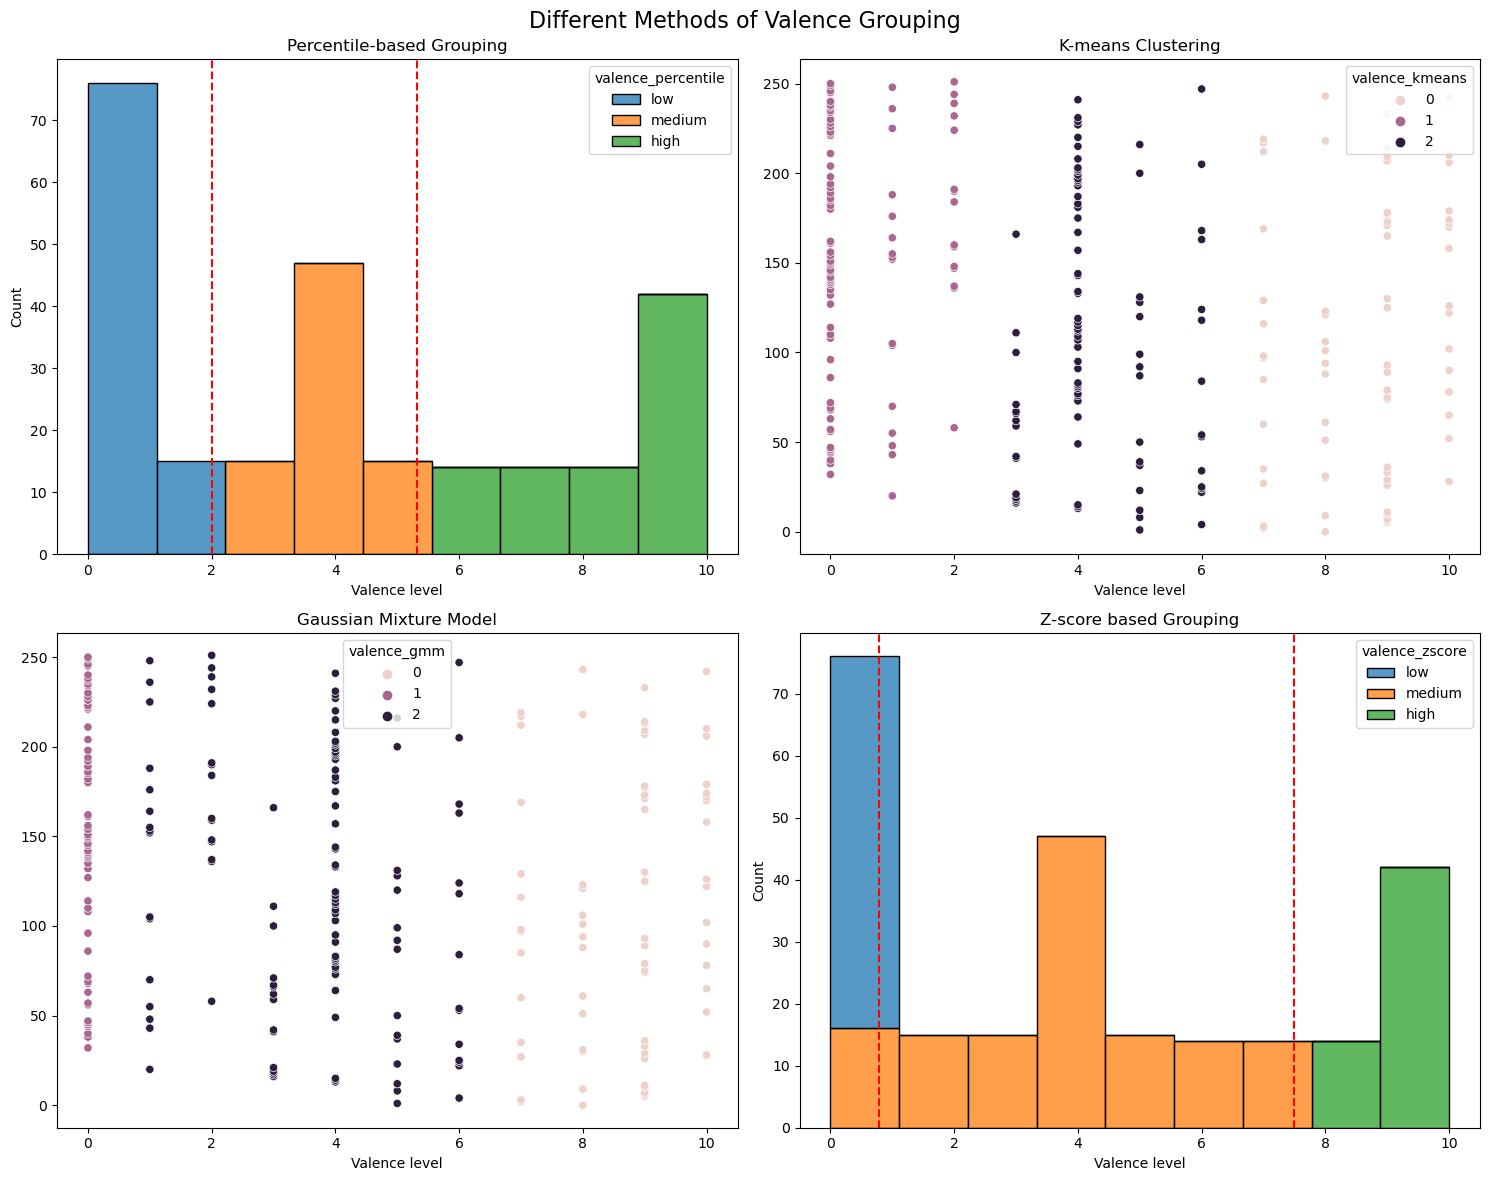

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde
import seaborn as sns

def analyze_valence_groupings(gsr_data):
    """
    Implement multiple methods for grouping valence ratings and correlate with GSR features
    """
    # 1. Statistical-based grouping using percentiles
    percentile_bounds = np.percentile(gsr_data['Valence level'], [33.33, 66.66])
    gsr_data['valence_percentile'] = pd.qcut(gsr_data['Valence level'], 
                                           q=3, 
                                           labels=['low', 'medium', 'high'])
    
    # 2. K-means clustering on valence levels
    kmeans = KMeans(n_clusters=3, random_state=42)
    gsr_data['valence_kmeans'] = kmeans.fit_predict(
        gsr_data['Valence level'].values.reshape(-1, 1)
    )
    
    # 3. Gaussian Mixture Model for natural groupings
    gmm = GaussianMixture(n_components=3, random_state=42)
    gsr_data['valence_gmm'] = gmm.fit_predict(
        gsr_data['Valence level'].values.reshape(-1, 1)
    )
    
    # 4. Dynamic thresholding using mean and std
    mean_val = gsr_data['Valence level'].mean()
    std_val = gsr_data['Valence level'].std()
    gsr_data['valence_zscore'] = pd.cut(
        gsr_data['Valence level'],
        bins=[float('-inf'), mean_val - std_val, mean_val + std_val, float('inf')],
        labels=['low', 'medium', 'high']
    )
    
    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Different Methods of Valence Grouping', fontsize=16)
    
    # Plot 1: Percentile-based
    sns.histplot(data=gsr_data, x='Valence level', hue='valence_percentile', 
                multiple="stack", ax=axes[0,0])
    axes[0,0].set_title('Percentile-based Grouping')
    axes[0,0].axvline(percentile_bounds[0], color='r', linestyle='--')
    axes[0,0].axvline(percentile_bounds[1], color='r', linestyle='--')
    
    # Plot 2: K-means
    sns.scatterplot(data=gsr_data, x='Valence level', y=gsr_data.index, 
                   hue='valence_kmeans', ax=axes[0,1])
    axes[0,1].set_title('K-means Clustering')
    
    # Plot 3: GMM
    sns.scatterplot(data=gsr_data, x='Valence level', y=gsr_data.index,
                   hue='valence_gmm', ax=axes[1,0])
    axes[1,0].set_title('Gaussian Mixture Model')
    
    # Plot 4: Z-score based
    sns.histplot(data=gsr_data, x='Valence level', hue='valence_zscore',
                multiple="stack", ax=axes[1,1])
    axes[1,1].set_title('Z-score based Grouping')
    axes[1,1].axvline(mean_val - std_val, color='r', linestyle='--')
    axes[1,1].axvline(mean_val + std_val, color='r', linestyle='--')
    
    plt.tight_layout()
    
    # Analyze correlation with GSR features
    def extract_basic_gsr_features(gsr_list):
        if isinstance(gsr_list, str):
            gsr_list = eval(gsr_list)
        gsr_array = np.array(gsr_list)
        return {
            'mean_gsr': np.mean(gsr_array),
            'std_gsr': np.std(gsr_array),
            'max_gsr': np.max(gsr_array),
            'min_gsr': np.min(gsr_array)
        }
    
    # Extract GSR features
    gsr_features = pd.DataFrame([extract_basic_gsr_features(gsr) 
                               for gsr in gsr_data['GSR_list']])
    
    # Calculate correlations for each grouping method
    grouping_methods = ['valence_percentile', 'valence_kmeans', 
                       'valence_gmm', 'valence_zscore']
    
    correlations = {}
    for method in grouping_methods:
        correlations[method] = {}
        for feature in gsr_features.columns:
            correlation = stats.spearmanr(
                pd.Categorical(gsr_data[method]).codes,
                gsr_features[feature]
            )
            correlations[method][feature] = correlation.correlation
    
    return pd.DataFrame(correlations)

# Run the analysis
correlation_results = analyze_valence_groupings(gsr_data)
print("\nCorrelation between GSR features and different grouping methods:")
print(correlation_results)

# Calculate silhouette scores for each method
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(gsr_data):
    valence_values = gsr_data['Valence level'].values.reshape(-1, 1)
    
    scores = {}
    for method, labels in [
        ('kmeans', gsr_data['valence_kmeans']),
        ('gmm', gsr_data['valence_gmm'])
    ]:
        score = silhouette_score(valence_values, labels)
        scores[method] = score
    
    return scores

silhouette_scores = calculate_silhouette_scores(gsr_data)
print("\nSilhouette Scores:")
print(silhouette_scores)

# VALENCE GROUPING VERSION 2
0-2 AS LOW
3- 6 AS MEDIUM
7 - 10 AS HIGH

In [12]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Print sorted unique values in the 'Valence level' column
unique_valence_levels = sorted(gsr_data["Valence level"].unique())
print("Sorted unique values in 'Valence level' column:")
print(unique_valence_levels)

# Create a new column for valence categories based on GROUPING VERSION 2
gsr_data["valence_category"] = pd.cut(
    gsr_data["Valence level"], 
    bins=[-1, 2, 6, 10],  # Define the boundaries for low, medium, and high
    labels=["low", "medium", "high"],  # Assign labels to categories
    include_lowest=True  # Include the lowest boundary in the first bin
)

# Create another column for target_valence by encoding the valence_category
valence_encoding = {"low": 0, "medium": 1, "high": 2}
gsr_data["target_valence"] = gsr_data["valence_category"].map(valence_encoding)

# Save the updated dataframe as gsr_valence
gsr_valence = gsr_data.copy()

# Display the first few rows of the new dataframe
print("\nUpdated DataFrame with valence_category and target_valence:")
print(gsr_valence.head())

# Function to extract statistical features from GSR signal
def extract_gsr_features(gsr_list):
    """
    Extract statistical features from GSR signal
    """
    # Convert string representation of list to actual list if needed
    if isinstance(gsr_list, str):
        gsr_list = eval(gsr_list)
    
    gsr_array = np.array(gsr_list)
    
    features = {
        'mean': np.mean(gsr_array),
        'std': np.std(gsr_array),
        'max': np.max(gsr_array),
        'min': np.min(gsr_array),
        'range': np.ptp(gsr_array),
        'median': np.median(gsr_array),
        'skewness': stats.skew(gsr_array),
        'kurtosis': stats.kurtosis(gsr_array),
        'q25': np.percentile(gsr_array, 25),
        'q75': np.percentile(gsr_array, 75),
        'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
    }
    
    return features

# Extract features from all GSR signals
features_list = []
for gsr in gsr_valence['GSR_list']:
    features = extract_gsr_features(gsr)
    features_list.append(features)

# Convert features to DataFrame
X = pd.DataFrame(features_list)

# Get target values
y = gsr_valence['target_valence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5)
print("\nCross-validation fold accuracies:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print("Average CV score:", cv_scores.mean())
print("CV score standard deviation:", cv_scores.std())

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
})
print("\nFeature Importance (top 5):")
print(feature_importance.sort_values('importance', ascending=False).head())


Sorted unique values in 'Valence level' column:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Updated DataFrame with valence_category and target_valence:
   Participant Id  Session ID  Video ID  Name  Age  Gender  Valence level  \
0               1           1         1   M_M   13  Female              8   
1               2           1         1   F_N   14    Male              5   
2               3           1         1   A_R   14    Male              7   
3               4           1         1  At_R   12    Male              7   
4               5           1         1   S_N   13    Male              6   

   Arousal level  Dominance level     Happy  ... Four_Labels  \
0              0                0      High  ...        HVLA   
1              2                0   VeryLow  ...        LVLA   
2              2                0      High  ...        HVLA   
3              2                0  Moderate  ...        HVLA   
4              0                9      High  ...        HVLA   

        

# GSR Features Clustering and Assigning Valence Label based on cluster

# Uses equally weighted average of self-reported ratings and the cluster based rating


Silhouette Analysis:
Average Silhouette Score: 0.5027

Cluster 0 Statistics:
Size: 185
Mean Silhouette: 0.5164
Min Silhouette: 0.2183
Max Silhouette: 0.6163

Cluster 1 Statistics:
Size: 29
Mean Silhouette: 0.3927
Min Silhouette: 0.0951
Max Silhouette: 0.4853

Cluster 2 Statistics:
Size: 38
Mean Silhouette: 0.5204
Min Silhouette: 0.1001
Max Silhouette: 0.6355


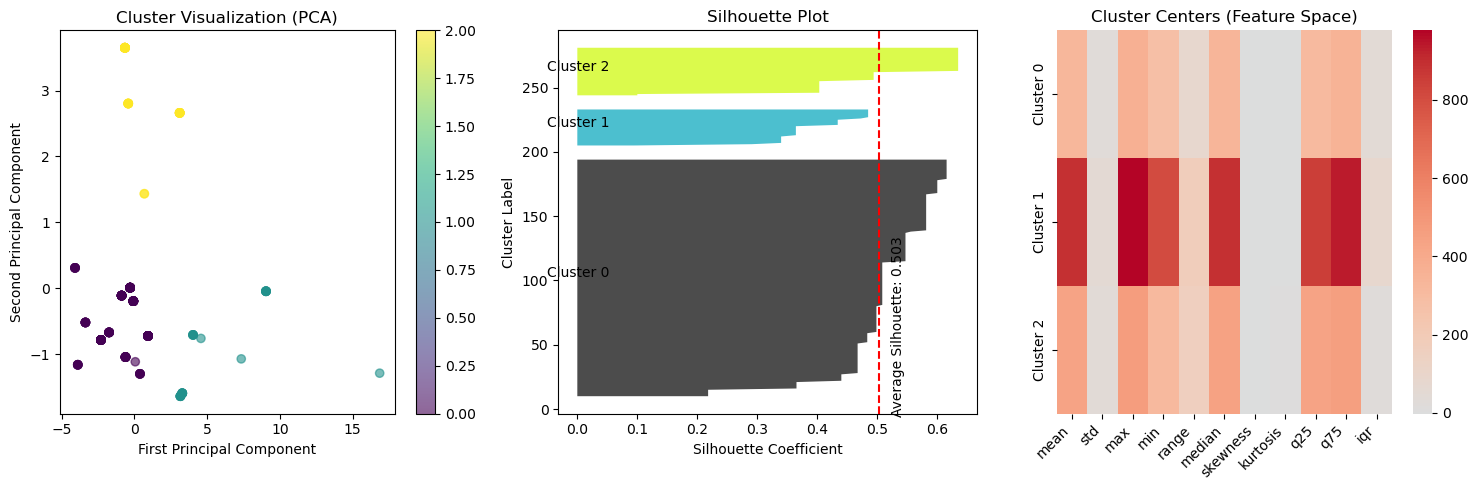


Cluster Statistics:
   Cluster  Size  Avg_Silhouette  Avg_Valence
0        0   185        0.516384     4.243243
1        1    29        0.392664     3.862069
2        2    38        0.520383     3.815789

Cross-validation scores:
Fold scores: [0.75609756 0.75       0.8        0.8        0.75      ]
Mean CV score: 0.7712 (±0.0236)

Classification Report:
              precision    recall  f1-score   support

         Low       0.81      0.81      0.81        27
      Medium       0.60      0.50      0.55        18
        High       0.44      0.67      0.53         6

    accuracy                           0.69        51
   macro avg       0.62      0.66      0.63        51
weighted avg       0.70      0.69      0.69        51


Silhouette Score for GSR clusters: 0.5027

Top 5 Most Important Features:
     feature  importance
7   kurtosis    0.233627
6   skewness    0.174524
10       iqr    0.093492
4      range    0.087042
0       mean    0.076005

Agreement between categorization met

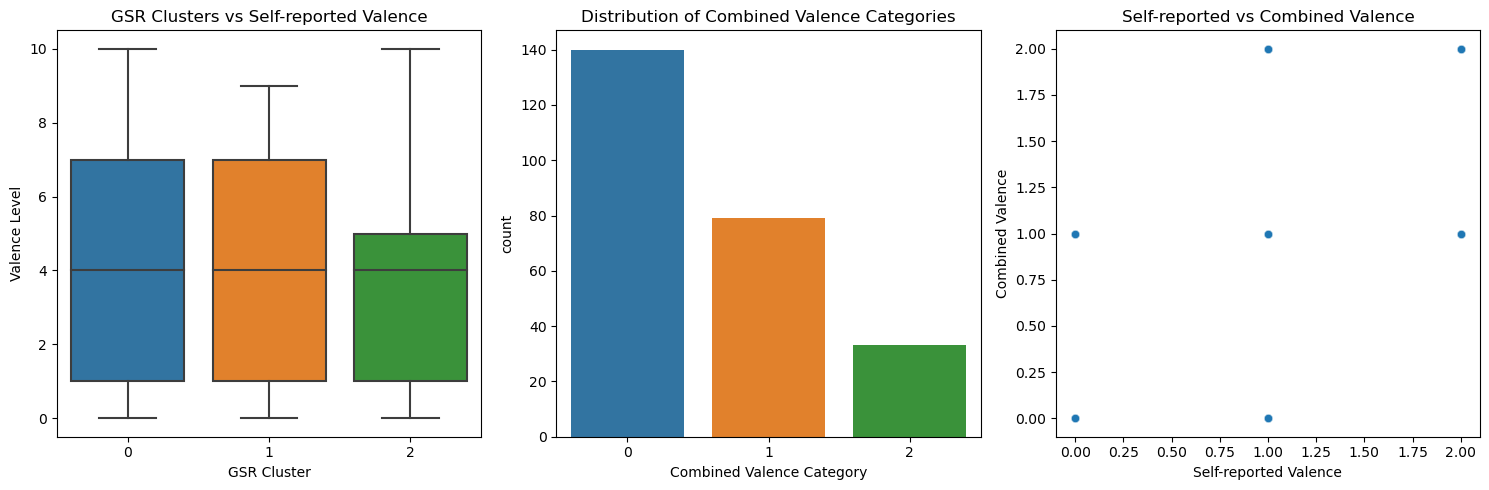

In [13]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Function to extract statistical features from GSR signal
def extract_gsr_features(gsr_list):
    """Extract statistical features from GSR signal"""
    if isinstance(gsr_list, str):
        gsr_list = eval(gsr_list)
    
    gsr_array = np.array(gsr_list)
    
    features = {
        'mean': np.mean(gsr_array),
        'std': np.std(gsr_array),
        'max': np.max(gsr_array),
        'min': np.min(gsr_array),
        'range': np.ptp(gsr_array),
        'median': np.median(gsr_array),
        'skewness': stats.skew(gsr_array),
        'kurtosis': stats.kurtosis(gsr_array),
        'q25': np.percentile(gsr_array, 25),
        'q75': np.percentile(gsr_array, 75),
        'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
    }
    
    return features

# Extract features from all GSR signals
features_list = []
for gsr in gsr_valence['GSR_list']:
    features = extract_gsr_features(gsr)
    features_list.append(features)

# Convert features to DataFrame
X = pd.DataFrame(features_list)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform K-means clustering on GSR features
kmeans = KMeans(n_clusters=3, random_state=42)
gsr_clusters = kmeans.fit_predict(X_scaled)

# Create a function for detailed cluster visualization
def visualize_clusters(X_pca, labels, silhouette_vals=None):
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Cluster visualization with PCA
    plt.subplot(131)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                         cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    # Plot 2: Silhouette plot
    if silhouette_vals is not None:
        plt.subplot(132)
        y_lower = 10
        for i in range(3):  # 3 clusters
            cluster_silhouette_vals = silhouette_vals[labels == i]
            cluster_silhouette_vals.sort()
            cluster_size = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + cluster_size
            
            color = cm.nipy_spectral(float(i) / 3)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, cluster_silhouette_vals,
                            facecolor=color, alpha=0.7)
            
            plt.text(-0.05, y_lower + 0.5 * cluster_size, f'Cluster {i}')
            y_lower = y_upper + 10
            
        plt.title('Silhouette Plot')
        plt.xlabel('Silhouette Coefficient')
        plt.ylabel('Cluster Label')
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.text(silhouette_avg + 0.02, plt.ylim()[0], 
                f'Average Silhouette: {silhouette_avg:.3f}',
                rotation=90)
    
    # Plot 3: Cluster Centers (in feature space)
    plt.subplot(133)
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=X.columns
    )
    
    # Plot heatmap of cluster centers
    sns.heatmap(cluster_centers, cmap='coolwarm', center=0,
                xticklabels=True, yticklabels=[f'Cluster {i}' for i in range(3)])
    plt.title('Cluster Centers (Feature Space)')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Calculate silhouette scores
silhouette_avg = silhouette_score(X_scaled, gsr_clusters)
silhouette_vals = silhouette_samples(X_scaled, gsr_clusters)

# Print detailed silhouette analysis
print("\nSilhouette Analysis:")
print(f"Average Silhouette Score: {silhouette_avg:.4f}")
for i in range(3):
    cluster_silhouette = silhouette_vals[gsr_clusters == i]
    print(f"\nCluster {i} Statistics:")
    print(f"Size: {len(cluster_silhouette)}")
    print(f"Mean Silhouette: {cluster_silhouette.mean():.4f}")
    print(f"Min Silhouette: {cluster_silhouette.min():.4f}")
    print(f"Max Silhouette: {cluster_silhouette.max():.4f}")

# Visualize the clusters
visualize_clusters(X_pca, gsr_clusters, silhouette_vals)

# Calculate cluster statistics
cluster_stats = pd.DataFrame({
    'Cluster': range(3),
    'Size': [sum(gsr_clusters == i) for i in range(3)],
    'Avg_Silhouette': [silhouette_vals[gsr_clusters == i].mean() for i in range(3)],
    'Avg_Valence': [gsr_valence[gsr_clusters == i]['Valence level'].mean() for i in range(3)]
})

print("\nCluster Statistics:")
print(cluster_stats)


# Add cluster labels to the original dataframe
gsr_valence['gsr_cluster'] = gsr_clusters

# Calculate mean valence level for each cluster
cluster_valence_means = gsr_valence.groupby('gsr_cluster')['Valence level'].mean()

# Fix the cluster mapping
# Convert to numpy array and get sorting indices
sorted_indices = np.argsort(cluster_valence_means.values)
labels = ['low', 'medium', 'high']
cluster_mapping = dict(zip(
    cluster_valence_means.index,
    [labels[i] for i in range(len(sorted_indices))]  # Assign labels in order
))

# Map clusters to valence categories based on mean valence levels
gsr_valence['cluster_based_category'] = gsr_valence['gsr_cluster'].map(cluster_mapping)

# Create combined valence category using both GSR clusters and self-reported valence
def combine_categories(row):
    # Convert self-reported valence to numeric (0-2)
    self_report = row['target_valence']
    # Convert cluster-based category to numeric
    cluster_based = ['low', 'medium', 'high'].index(row['cluster_based_category'])
    # Take weighted average (adjust weights as needed)
    combined = (0.5 * self_report + 0.5 * cluster_based)
    # Convert back to categorical
    if combined <= 0.67:
        return 0  # low
    elif combined <= 1.33:
        return 1  # medium
    else:
        return 2  # high

gsr_valence['combined_valence'] = gsr_valence.apply(combine_categories, axis=1)

# Visualize the relationships
plt.figure(figsize=(15, 5))

# Plot 1: GSR Clusters vs Self-reported Valence
plt.subplot(131)
sns.boxplot(x='gsr_cluster', y='Valence level', data=gsr_valence)
plt.title('GSR Clusters vs Self-reported Valence')
plt.xlabel('GSR Cluster')
plt.ylabel('Valence Level')

# Plot 2: Distribution of Combined Categories
plt.subplot(132)
sns.countplot(x='combined_valence', data=gsr_valence)
plt.title('Distribution of Combined Valence Categories')
plt.xlabel('Combined Valence Category')

# Plot 3: Comparison of Classifications
plt.subplot(133)
sns.scatterplot(data=gsr_valence, x='target_valence', y='combined_valence', alpha=0.5)
plt.title('Self-reported vs Combined Valence')
plt.xlabel('Self-reported Valence')
plt.ylabel('Combined Valence')

plt.tight_layout()

# Train model using combined valence categories
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, gsr_valence['combined_valence'], test_size=0.2, random_state=42
)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
print("\nCross-validation scores:")
print(f"Fold scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Make predictions and print classification report
y_pred = rf_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Evaluate clustering quality
silhouette_avg = silhouette_score(X_scaled, gsr_clusters)
print(f"\nSilhouette Score for GSR clusters: {silhouette_avg:.4f}")

# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
})
print("\nTop 5 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head())

# Calculate agreement between different categorization methods
agreement_stats = pd.DataFrame({
    'Self_vs_Cluster': (gsr_valence['target_valence'] == 
                       pd.Categorical(gsr_valence['cluster_based_category']).codes).mean(),
    'Self_vs_Combined': (gsr_valence['target_valence'] == 
                        gsr_valence['combined_valence']).mean(),
    'Cluster_vs_Combined': (pd.Categorical(gsr_valence['cluster_based_category']).codes == 
                           gsr_valence['combined_valence']).mean()
}, index=['Agreement'])

print("\nAgreement between categorization methods:")
print(agreement_stats)

# Using purely clustering based categories for training


Silhouette Analysis:
Average Silhouette Score: 0.5027

Cluster 0 Statistics:
Size: 185
Mean Silhouette: 0.5164
Min Silhouette: 0.2183
Max Silhouette: 0.6163

Cluster 1 Statistics:
Size: 29
Mean Silhouette: 0.3927
Min Silhouette: 0.0951
Max Silhouette: 0.4853

Cluster 2 Statistics:
Size: 38
Mean Silhouette: 0.5204
Min Silhouette: 0.1001
Max Silhouette: 0.6355


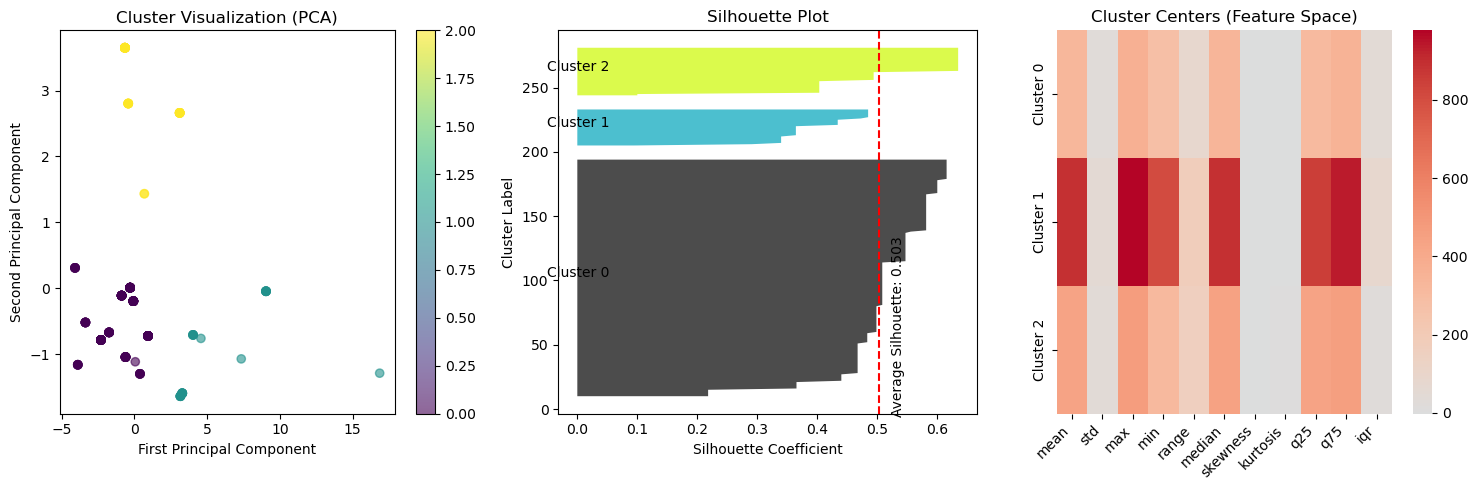


Cluster Statistics:
   Cluster  Size  Avg_Silhouette  Avg_Valence
0        0   185        0.516384     4.243243
1        1    29        0.392664     3.862069
2        2    38        0.520383     3.815789

Cross-validation scores:

Cross-validation scores:
Fold 1: 1.0000
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 0.9750
Fold 5: 1.0000
Mean CV score: 0.9950 (±0.0100)

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         6
      Medium       1.00      1.00      1.00        37
        High       1.00      1.00      1.00         8

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51


Silhouette Score for GSR clusters: 0.5027

Top 5 Most Important Features:
    feature  importance
7  kurtosis    0.285793
6  skewness    0.208352
0      mean    0.121176
8       q25    0.079164
9       q75    0.073931

Agreement b

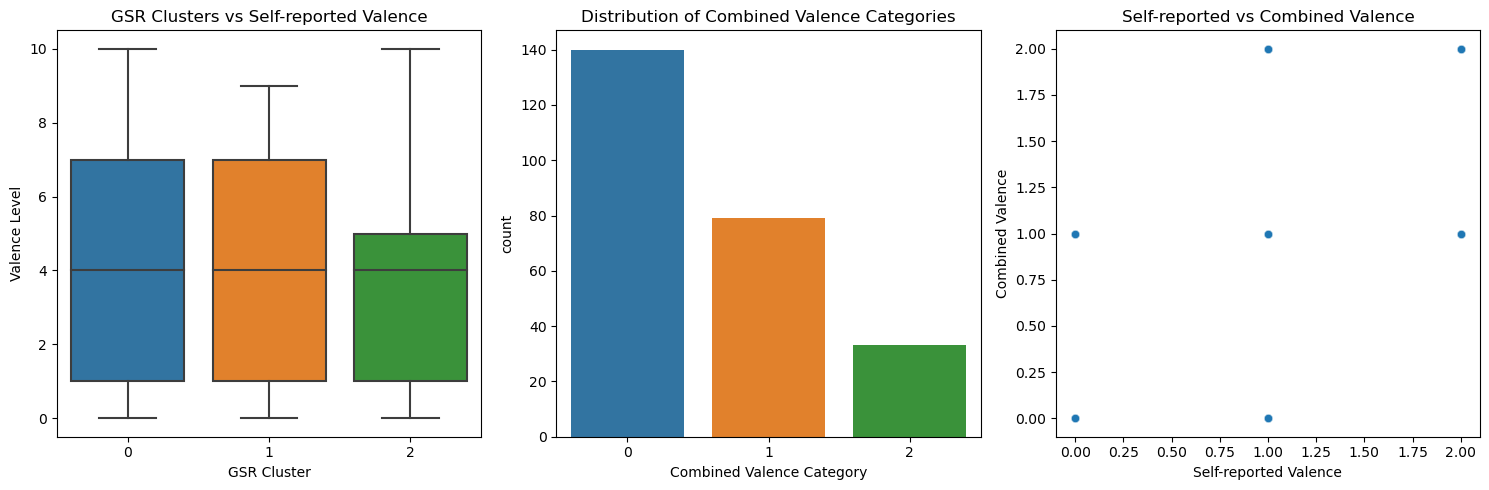

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Function to extract statistical features from GSR signal
def extract_gsr_features(gsr_list):
    """Extract statistical features from GSR signal"""
    if isinstance(gsr_list, str):
        gsr_list = eval(gsr_list)
    
    gsr_array = np.array(gsr_list)
    
    features = {
        'mean': np.mean(gsr_array),
        'std': np.std(gsr_array),
        'max': np.max(gsr_array),
        'min': np.min(gsr_array),
        'range': np.ptp(gsr_array),
        'median': np.median(gsr_array),
        'skewness': stats.skew(gsr_array),
        'kurtosis': stats.kurtosis(gsr_array),
        'q25': np.percentile(gsr_array, 25),
        'q75': np.percentile(gsr_array, 75),
        'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
    }
    
    return features

# Extract features from all GSR signals
features_list = []
for gsr in gsr_valence['GSR_list']:
    features = extract_gsr_features(gsr)
    features_list.append(features)

# Convert features to DataFrame
X = pd.DataFrame(features_list)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform K-means clustering on GSR features
kmeans = KMeans(n_clusters=3, random_state=42)
gsr_clusters = kmeans.fit_predict(X_scaled)

# Create a function for detailed cluster visualization
def visualize_clusters(X_pca, labels, silhouette_vals=None):
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Cluster visualization with PCA
    plt.subplot(131)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                         cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    # Plot 2: Silhouette plot
    if silhouette_vals is not None:
        plt.subplot(132)
        y_lower = 10
        for i in range(3):  # 3 clusters
            cluster_silhouette_vals = silhouette_vals[labels == i]
            cluster_silhouette_vals.sort()
            cluster_size = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + cluster_size
            
            color = cm.nipy_spectral(float(i) / 3)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, cluster_silhouette_vals,
                            facecolor=color, alpha=0.7)
            
            plt.text(-0.05, y_lower + 0.5 * cluster_size, f'Cluster {i}')
            y_lower = y_upper + 10
            
        plt.title('Silhouette Plot')
        plt.xlabel('Silhouette Coefficient')
        plt.ylabel('Cluster Label')
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.text(silhouette_avg + 0.02, plt.ylim()[0], 
                f'Average Silhouette: {silhouette_avg:.3f}',
                rotation=90)
    
    # Plot 3: Cluster Centers (in feature space)
    plt.subplot(133)
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=X.columns
    )
    
    # Plot heatmap of cluster centers
    sns.heatmap(cluster_centers, cmap='coolwarm', center=0,
                xticklabels=True, yticklabels=[f'Cluster {i}' for i in range(3)])
    plt.title('Cluster Centers (Feature Space)')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Calculate silhouette scores
silhouette_avg = silhouette_score(X_scaled, gsr_clusters)
silhouette_vals = silhouette_samples(X_scaled, gsr_clusters)

# Print detailed silhouette analysis
print("\nSilhouette Analysis:")
print(f"Average Silhouette Score: {silhouette_avg:.4f}")
for i in range(3):
    cluster_silhouette = silhouette_vals[gsr_clusters == i]
    print(f"\nCluster {i} Statistics:")
    print(f"Size: {len(cluster_silhouette)}")
    print(f"Mean Silhouette: {cluster_silhouette.mean():.4f}")
    print(f"Min Silhouette: {cluster_silhouette.min():.4f}")
    print(f"Max Silhouette: {cluster_silhouette.max():.4f}")

# Visualize the clusters
visualize_clusters(X_pca, gsr_clusters, silhouette_vals)

# Calculate cluster statistics
cluster_stats = pd.DataFrame({
    'Cluster': range(3),
    'Size': [sum(gsr_clusters == i) for i in range(3)],
    'Avg_Silhouette': [silhouette_vals[gsr_clusters == i].mean() for i in range(3)],
    'Avg_Valence': [gsr_valence[gsr_clusters == i]['Valence level'].mean() for i in range(3)]
})

print("\nCluster Statistics:")
print(cluster_stats)


# Add cluster labels to the original dataframe
gsr_valence['gsr_cluster'] = gsr_clusters

# Calculate mean valence level for each cluster
cluster_valence_means = gsr_valence.groupby('gsr_cluster')['Valence level'].mean()

# Fix the cluster mapping
# Convert to numpy array and get sorting indices
sorted_indices = np.argsort(cluster_valence_means.values)
labels = ['low', 'medium', 'high']
cluster_mapping = dict(zip(
    cluster_valence_means.index,
    [labels[i] for i in range(len(sorted_indices))]  # Assign labels in order
))

# Map clusters to valence categories based on mean valence levels
gsr_valence['cluster_based_category'] = gsr_valence['gsr_cluster'].map(cluster_mapping)

# Create combined valence category using both GSR clusters and self-reported valence
def combine_categories(row):
    # Convert self-reported valence to numeric (0-2)
    self_report = row['target_valence']
    # Convert cluster-based category to numeric
    cluster_based = ['low', 'medium', 'high'].index(row['cluster_based_category'])
    # Take weighted average (adjust weights as needed)
    combined = (0.5 * self_report + 0.5 * cluster_based)
    # Convert back to categorical
    if combined <= 0.67:
        return 0  # low
    elif combined <= 1.33:
        return 1  # medium
    else:
        return 2  # high

gsr_valence['combined_valence'] = gsr_valence.apply(combine_categories, axis=1)

# Visualize the relationships
plt.figure(figsize=(15, 5))

# Plot 1: GSR Clusters vs Self-reported Valence
plt.subplot(131)
sns.boxplot(x='gsr_cluster', y='Valence level', data=gsr_valence)
plt.title('GSR Clusters vs Self-reported Valence')
plt.xlabel('GSR Cluster')
plt.ylabel('Valence Level')

# Plot 2: Distribution of Combined Categories
plt.subplot(132)
sns.countplot(x='combined_valence', data=gsr_valence)
plt.title('Distribution of Combined Valence Categories')
plt.xlabel('Combined Valence Category')

# Plot 3: Comparison of Classifications
plt.subplot(133)
sns.scatterplot(data=gsr_valence, x='target_valence', y='combined_valence', alpha=0.5)
plt.title('Self-reported vs Combined Valence')
plt.xlabel('Self-reported Valence')
plt.ylabel('Combined Valence')

plt.tight_layout()

# Convert cluster_based_category to numeric codes
cluster_based_numeric = pd.Categorical(gsr_valence['cluster_based_category']).codes

# Train model using only cluster-based categories
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, cluster_based_numeric, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
print("\nCross-validation scores:")
print("\nCross-validation scores:")
for fold, score in enumerate(cv_scores, 1):
    print(f"Fold {fold}: {score:.4f}")
print(f"Mean CV score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Make predictions and print classification report
y_pred = rf_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Evaluate clustering quality
silhouette_avg = silhouette_score(X_scaled, gsr_clusters)
print(f"\nSilhouette Score for GSR clusters: {silhouette_avg:.4f}")

# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
})
print("\nTop 5 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head())

# Calculate agreement between different categorization methods
agreement_stats = pd.DataFrame({
    'Self_vs_Cluster': (gsr_valence['target_valence'] == 
                       pd.Categorical(gsr_valence['cluster_based_category']).codes).mean(),
    'Self_vs_Combined': (gsr_valence['target_valence'] == 
                        gsr_valence['combined_valence']).mean(),
    'Cluster_vs_Combined': (pd.Categorical(gsr_valence['cluster_based_category']).codes == 
                           gsr_valence['combined_valence']).mean()
}, index=['Agreement'])

print("\nAgreement between categorization methods:")
print(agreement_stats)

# Analyse cluster to valence mapping - what each cluster represents

In [15]:
# Analyze cluster to valence mapping
analysis_df = pd.DataFrame()

# Calculate mean and mode manually for each cluster
cluster_means = gsr_valence.groupby('gsr_cluster')['Valence level'].mean().round(3)
cluster_sizes = gsr_valence.groupby('gsr_cluster').size()

# Calculate mode for each cluster
cluster_modes = gsr_valence.groupby('gsr_cluster')['Valence level'].agg(
    lambda x: x.value_counts().index[0]
).round(3)

# Create intermediate dataframe
cluster_stats = pd.DataFrame({
    'mean_valence': cluster_means,
    'mode_valence': cluster_modes,
    'cluster_size': cluster_sizes
})

# Sort clusters by mean valence to determine low/medium/high mapping
cluster_stats = cluster_stats.sort_values('mean_valence')

# Assign categories based on ordered mean valence
categories = ['low', 'medium', 'high']
cluster_stats['valence_category'] = categories

# Create final dataframe with cluster mappings
result_df = pd.DataFrame({
    'cluster_number': cluster_stats.index,
    'valence_category': cluster_stats['valence_category'],
    'mean_valence': cluster_stats['mean_valence'],
    'mode_valence': cluster_stats['mode_valence'],
    'cluster_size': cluster_stats['cluster_size']
})

print("\nCluster Analysis Results:")
print(result_df)

# Create mapping dictionary for future use
cluster_to_valence = dict(zip(result_df['cluster_number'], result_df['valence_category']))
print("\nCluster to Valence Category Mapping:")
print(cluster_to_valence)


Cluster Analysis Results:
             cluster_number valence_category  mean_valence  mode_valence  \
gsr_cluster                                                                
2                         2              low         3.816             4   
1                         1           medium         3.862             4   
0                         0             high         4.243             0   

             cluster_size  
gsr_cluster                
2                      38  
1                      29  
0                     185  

Cluster to Valence Category Mapping:
{2: 'low', 1: 'medium', 0: 'high'}


# Using Pearson Correlation Analysis to use only the most important features to train the model

In [16]:
# Create a DataFrame with features and target
feature_data = pd.DataFrame(X_scaled, columns=X.columns)
feature_data['target'] = cluster_based_numeric

# Calculate Pearson correlations
correlations = {}
for feature in X.columns:
    correlation = np.abs(stats.pearsonr(feature_data[feature], feature_data['target'])[0])
    correlations[feature] = correlation

# Convert to DataFrame and sort
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
correlation_df = correlation_df.sort_values('correlation', ascending=False)

# Print correlation results
print("\nFeature Correlations with Target (absolute values):")
print(correlation_df)

# Select features with correlation above threshold (e.g., 0.1)
correlation_threshold = 0.1
selected_features = correlation_df[correlation_df['correlation'] > correlation_threshold].index.tolist()

print(f"\nSelected {len(selected_features)} features with correlation > {correlation_threshold}:")
print(selected_features)

# Create new feature matrix with selected features only
X_selected = X_scaled[:, [list(X.columns).index(feature) for feature in selected_features]]

# Split the data using selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, cluster_based_numeric, test_size=0.2, random_state=42
)

# Train Random Forest with selected features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_selected, y_train)

# Perform cross-validation with selected features
cv_scores = cross_val_score(rf_classifier, X_train_selected, y_train, cv=5)
print("\nCross-validation scores with selected features:")
for fold, score in enumerate(cv_scores, 1):
    print(f"Fold {fold}: {score:.4f}")
print(f"Mean CV score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Make predictions and print classification report
y_pred = rf_classifier.predict(X_test_selected)
print("\nClassification Report with selected features:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Analyze feature importance of selected features
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_classifier.feature_importances_
})
print("\nTop 5 Most Important Selected Features:")
print(feature_importance.sort_values('importance', ascending=False).head())


Feature Correlations with Target (absolute values):
          correlation
skewness     0.737720
kurtosis     0.722369
min          0.547271
max          0.456492
q75          0.451839
mean         0.450052
median       0.432607
iqr          0.414712
q25          0.409229
std          0.083593
range        0.000734

Selected 9 features with correlation > 0.1:
['skewness', 'kurtosis', 'min', 'max', 'q75', 'mean', 'median', 'iqr', 'q25']

Cross-validation scores with selected features:
Fold 1: 1.0000
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 0.9750
Fold 5: 1.0000
Mean CV score: 0.9950 (±0.0100)

Classification Report with selected features:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         6
      Medium       1.00      1.00      1.00        37
        High       1.00      1.00      1.00         8

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.

# Don't use this as the accuracy is too low with test data: Save and load model trained on selected features with correlation more than 0.1 & preprocess

In [17]:
import joblib
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

class GSRPreprocessor:
    """Class for preprocessing GSR data and making predictions"""
    
    def __init__(self):
        self.selected_features = [
            'kurtosis', 'min', 'max', 'q75', 'mean',
            'median', 'iqr', 'q25', 'std', 'range'
        ]
        self.scaler = None
        self.model = None
        
    def extract_features(self, gsr_list):
        """Extract statistical features from a single GSR signal"""
        if isinstance(gsr_list, str):
            gsr_list = eval(gsr_list)
        
        gsr_array = np.array(gsr_list)
        
        features = {
            'mean': np.mean(gsr_array),
            'std': np.std(gsr_array),
            'max': np.max(gsr_array),
            'min': np.min(gsr_array),
            'range': np.ptp(gsr_array),
            'median': np.median(gsr_array),
            'skewness': stats.skew(gsr_array),
            'kurtosis': stats.kurtosis(gsr_array),
            'q25': np.percentile(gsr_array, 25),
            'q75': np.percentile(gsr_array, 75),
            'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
        }
        
        # Only return selected features
        return {k: features[k] for k in self.selected_features}
    
    def preprocess_gsr_data(self, gsr_list):
        """Preprocess a single GSR signal for prediction"""
        # Extract features
        features = self.extract_features(gsr_list)
        
        # Convert to DataFrame
        X = pd.DataFrame([features])
        
        # Scale features
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
            return X_scaled
        else:
            raise ValueError("Scaler not fitted. Call fit() or load a saved preprocessor first.")
    
    def fit(self, X, y):
        """Fit the preprocessor and model"""
        # Initialize and fit scaler
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Initialize and fit model
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(X_scaled, y)
        
        return self
    
    def predict(self, gsr_list):
        """Predict valence category for a single GSR signal"""
        if self.model is None:
            raise ValueError("Model not fitted. Call fit() or load a saved preprocessor first.")
        
        # Preprocess the data
        X_scaled = self.preprocess_gsr_data(gsr_list)
        
        # Make prediction
        prediction = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)
        
        # Map numeric prediction to category
        category_map = {0: 'low', 1: 'medium', 2: 'high'}
        category = category_map[prediction[0]]
        
        return {
            'category': category,
            'probabilities': {
                'low': probabilities[0][0],
                'medium': probabilities[0][1],
                'high': probabilities[0][2]
            }
        }
    
    def save(self, filepath):
        """Save the preprocessor and model"""
        if self.scaler is None or self.model is None:
            raise ValueError("Preprocessor and model must be fitted before saving")
        
        save_dict = {
            'scaler': self.scaler,
            'model': self.model,
            'selected_features': self.selected_features
        }
        joblib.dump(save_dict, filepath)
    
    def load(self, filepath):
        """Load a saved preprocessor and model"""
        load_dict = joblib.load(filepath)
        self.scaler = load_dict['scaler']
        self.model = load_dict['model']
        self.selected_features = load_dict['selected_features']
        return self

# Add this code after your model training to save the model:
# Create and fit the preprocessor
preprocessor = GSRPreprocessor()
preprocessor.fit(
    X[[feature for feature in X.columns if feature in preprocessor.selected_features]],
    cluster_based_numeric
)

# Save the fitted preprocessor and model
preprocessor.save('gsr_valence_model_selected_feats.joblib')

# Example of how to load and use the model for new predictions:
def predict_valence_from_gsr(gsr_signal):
    """Predict valence category from a new GSR signal"""
    # Load the saved preprocessor and model
    preprocessor = GSRPreprocessor()
    preprocessor.load('gsr_valence_model.joblib')
    
    # Make prediction
    result = preprocessor.predict(gsr_signal)
    
    return result

# Example usage:
# sample_gsr = [0.1, 0.2, 0.3, 0.4, 0.5]  # Replace with actual GSR signal
# prediction = predict_valence_from_gsr(sample_gsr)
# print(f"Predicted category: {prediction['category']}")
# print(f"Prediction probabilities: {prediction['probabilities']}")

# Add this code after saving the model

def evaluate_test_predictions(preprocessor, X_test, y_test):
    """Evaluate model predictions on test data"""
    # Get predictions for all test samples
    predictions = []
    probabilities = []
    
    # Convert test data back to original GSR features
    X_test_original = preprocessor.scaler.inverse_transform(X_test)
    X_test_df = pd.DataFrame(X_test_original, columns=preprocessor.selected_features)
    
    # Create dummy GSR lists for testing
    # This simulates the original GSR data structure expected by the preprocessor
    dummy_gsr_lists = []
    for _, row in X_test_df.iterrows():
        # Create a simple GSR signal that will generate the same features
        dummy_gsr = [row['mean']] * 5  # Simplified dummy data
        dummy_gsr_lists.append(dummy_gsr)
    
    # Get predictions for each test sample
    for gsr in dummy_gsr_lists:
        result = preprocessor.predict(gsr)
        predictions.append(result['category'])
        probabilities.append(result['probabilities'])
    
    # Calculate accuracy
    predicted_categories = [['low', 'medium', 'high'].index(pred) for pred in predictions]
    accuracy = sum(pred == true for pred, true in zip(predicted_categories, y_test)) / len(y_test)
    
    # Print results
    print("\nTest Data Evaluation Results:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nDetailed Results:")
    print(classification_report(y_test, predicted_categories, target_names=['Low', 'Medium', 'High']))
    
    # Return detailed results for further analysis if needed
    return {
        'predictions': predictions,
        'probabilities': probabilities,
        'accuracy': accuracy
    }
# First, ensure we're using all selected features
print("Available features:", X.columns.tolist())
print("Selected features:", preprocessor.selected_features)

# Create and fit the preprocessor with the training data
preprocessor = GSRPreprocessor()

# Get the selected features from training data
X_selected = X[preprocessor.selected_features]
print(f"\nTraining data shape: {X_selected.shape}")

# Split the data using selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, cluster_based_numeric, test_size=0.2, random_state=42
)
print(f"Test data shape: {X_test_selected.shape}")

# Fit the preprocessor with training data
preprocessor.fit(X_train_selected, y_train)

# Save the fitted preprocessor and model
preprocessor.save('gsr_valence_model_selected_feats.joblib')

def evaluate_test_predictions(preprocessor, X_test, y_test):
    """Evaluate model predictions on test data"""
    # Get predictions directly using the model
    predictions = preprocessor.model.predict(X_test)
    probabilities = preprocessor.model.predict_proba(X_test)
    
    # Convert numeric predictions to categories
   # Cluster to Valence Category Mapping:
# {2: 'low', 1: 'medium', 0: 'high'}
    category_map = {2: 'low', 1: 'medium', 0: 'high'}
    prediction_categories = [category_map[pred] for pred in predictions]
    
    # Format probabilities
    probability_dicts = []
    for prob in probabilities:
        probability_dicts.append({
            'low': prob[2],
            'medium': prob[1],
            'high': prob[0]
        })
    
    # Calculate accuracy
    accuracy = sum(pred == true for pred, true in zip(predictions, y_test)) / len(y_test)
    
    # Print results
    print("\nTest Data Evaluation Results:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nDetailed Results:")
    print(classification_report(y_test, predictions, target_names=['Low', 'Medium', 'High']))
    
    return {
        'predictions': prediction_categories,
        'probabilities': probability_dicts,
        'accuracy': accuracy
    }

# Load the model and evaluate on test data
loaded_preprocessor = GSRPreprocessor()
loaded_preprocessor.load('gsr_valence_model_selected_feats.joblib')

# Verify features match
print("\nModel features:", loaded_preprocessor.selected_features)
print("Test data features:", X_test_selected.columns.tolist())

# Ensure test data has the same features in the same order
X_test_selected = X_test_selected[loaded_preprocessor.selected_features]

# Evaluate the model on test data
results = evaluate_test_predictions(loaded_preprocessor, X_test_selected, y_test)

# Print some example predictions
print("\nExample Individual Predictions:")
for i in range(min(5, len(X_test_selected))):  # Show first 5 predictions
    print(f"\nTest Sample {i+1}:")
    print(f"True category: {['low', 'medium', 'high'][y_test[i]]}")
    print(f"Predicted category: {results['predictions'][i]}")
    print(f"Prediction probabilities: {results['probabilities'][i]}")

# Additional analysis of predictions
prediction_distribution = pd.Series(results['predictions']).value_counts()
print("\nPrediction Distribution:")
print(prediction_distribution)

# Calculate confidence metrics
confidence_metrics = pd.DataFrame(results['probabilities'])
print("\nConfidence Statistics:")
print(confidence_metrics.agg(['mean', 'std', 'min', 'max']).round(3))

Available features: ['mean', 'std', 'max', 'min', 'range', 'median', 'skewness', 'kurtosis', 'q25', 'q75', 'iqr']
Selected features: ['kurtosis', 'min', 'max', 'q75', 'mean', 'median', 'iqr', 'q25', 'std', 'range']

Training data shape: (252, 10)
Test data shape: (51, 10)

Model features: ['kurtosis', 'min', 'max', 'q75', 'mean', 'median', 'iqr', 'q25', 'std', 'range']
Test data features: ['kurtosis', 'min', 'max', 'q75', 'mean', 'median', 'iqr', 'q25', 'std', 'range']

Test Data Evaluation Results:
Overall Accuracy: 0.1569

Detailed Results:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         6
      Medium       0.00      0.00      0.00        37
        High       0.16      1.00      0.27         8

    accuracy                           0.16        51
   macro avg       0.05      0.33      0.09        51
weighted avg       0.02      0.16      0.04        51


Example Individual Predictions:

Test Sample 1:
True category: medium

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

# Synthetic Data Generation with SMOTE (to handle class imbalance)


Original class distribution:
[(0, 38), (1, 185), (2, 29)]

Balanced class distribution after SMOTE:
[(0, 185), (1, 185), (2, 185)]

Cross-validation scores with balanced dataset:
Fold 1: 1.0000
Fold 2: 1.0000
Fold 3: 1.0000
Fold 4: 1.0000
Fold 5: 1.0000
Mean CV score: 1.0000 (±0.0000)

Classification Report with balanced dataset:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        34
      Medium       1.00      1.00      1.00        37
        High       1.00      1.00      1.00        40

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111


Top 5 Most Important Features (Balanced Dataset):
    feature  importance
7  kurtosis    0.261914
6  skewness    0.162711
0      mean    0.131853
2       max    0.097136
9       q75    0.097027


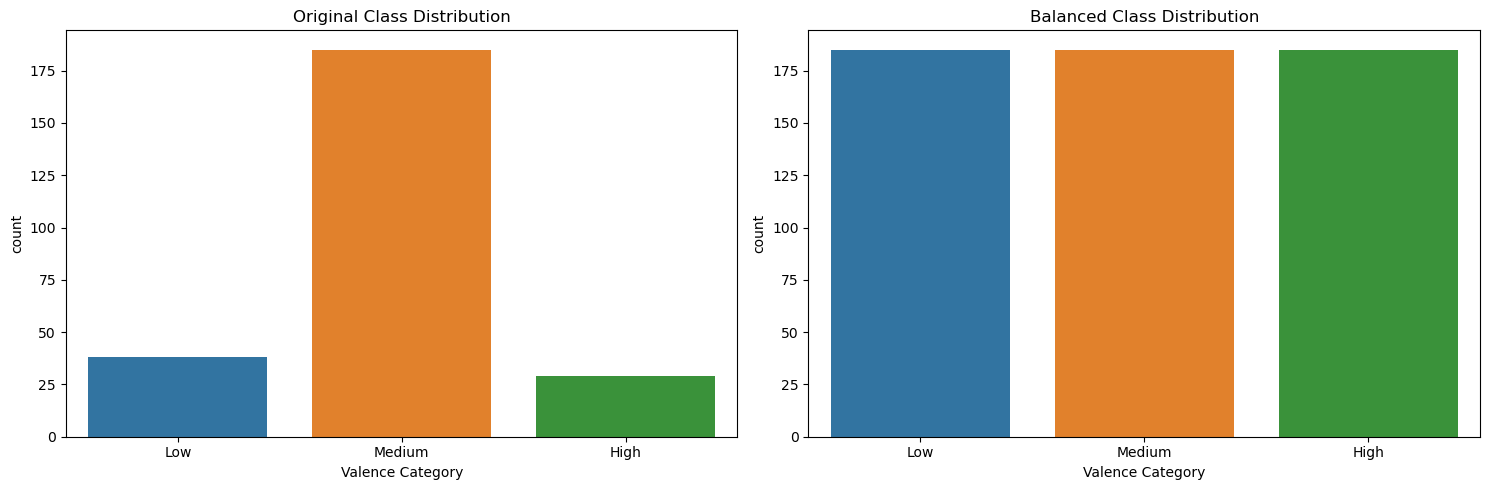

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Print original class distribution
print("\nOriginal class distribution:")
print(sorted(Counter(cluster_based_numeric).items()))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
# Note: We'll use X_scaled with all features to ensure better synthetic data quality
X_balanced, y_balanced = smote.fit_resample(X_scaled, cluster_based_numeric)

# Print new class distribution
print("\nBalanced class distribution after SMOTE:")
print(sorted(Counter(y_balanced).items()))

# Split the balanced dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

# Train Random Forest on balanced dataset
rf_classifier_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_balanced.fit(X_train_balanced, y_train_balanced)

# Perform cross-validation on balanced dataset
cv_scores_balanced = cross_val_score(rf_classifier_balanced, X_train_balanced, y_train_balanced, cv=5)
print("\nCross-validation scores with balanced dataset:")
for fold, score in enumerate(cv_scores_balanced, 1):
    print(f"Fold {fold}: {score:.4f}")
print(f"Mean CV score: {cv_scores_balanced.mean():.4f} (±{cv_scores_balanced.std():.4f})")

# Make predictions and print classification report for balanced dataset
y_pred_balanced = rf_classifier_balanced.predict(X_test_balanced)
print("\nClassification Report with balanced dataset:")
print(classification_report(y_test_balanced, y_pred_balanced, target_names=['Low', 'Medium', 'High']))

# Compare feature importance for balanced dataset
feature_importance_balanced = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier_balanced.feature_importances_
})
print("\nTop 5 Most Important Features (Balanced Dataset):")
print(feature_importance_balanced.sort_values('importance', ascending=False).head())

# Create visualizations to compare original vs balanced data distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original data distribution
sns.countplot(x=cluster_based_numeric, ax=ax1)
ax1.set_title('Original Class Distribution')
ax1.set_xlabel('Valence Category')
ax1.set_xticklabels(['Low', 'Medium', 'High'])

# Balanced data distribution
sns.countplot(x=y_balanced, ax=ax2)
ax2.set_title('Balanced Class Distribution')
ax2.set_xlabel('Valence Category')
ax2.set_xticklabels(['Low', 'Medium', 'High'])

plt.tight_layout()
plt.show()

# SAVE MODEL FOR FUTURE USE trained on ALL features

In [19]:
import joblib

# Save the trained Random Forest Classifier
model_filename = "gsr_valence_rf_classifier_model.pkl"
joblib.dump(rf_classifier, model_filename)
print(f"Model saved to {model_filename}")

# Save the scaler for preprocessing later
scaler_filename = "gsr_valence_scaler.pkl"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

# Save the feature importance dataframe
feature_importance_filename = "gsr_valence_feature_importance.csv"
feature_importance.to_csv(feature_importance_filename, index=False)
print(f"Feature importance saved to {feature_importance_filename}")

# Save processed data for reproducibility
processed_data_filename = "gsr_valence_processed.csv"
gsr_valence.to_csv(processed_data_filename, index=False)
print(f"Processed data saved to {processed_data_filename}")


Model saved to gsr_valence_rf_classifier_model.pkl
Scaler saved to gsr_valence_scaler.pkl
Feature importance saved to gsr_valence_feature_importance.csv
Processed data saved to gsr_valence_processed.csv


# Load model and predict 7 feb 617 pm CORRECT VERSION

In [27]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats

# Cluster to Valence Category Mapping:
# {2: 'low', 1: 'medium', 0: 'high'}

class GSRProcessor:
    def __init__(self, model_path, scaler_path):
        """
        Initialize the GSR processor with trained model and scaler
        
        Parameters:
        model_path (str): Path to the saved model file
        scaler_path (str): Path to the saved scaler file
        """
        # Load the model and scaler
        self.model =joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)

    
    def extract_features(self, gsr_signal):
        """
        Extract features from GSR signal
        
        Parameters:
        gsr_signal (array): Raw GSR signal
        
        Returns:
        dict: Dictionary containing extracted features
        """
        gsr_array = np.array(gsr_signal)
        
        features = {
            'mean': np.mean(gsr_array),
            'std': np.std(gsr_array),
            'max': np.max(gsr_array),
            'min': np.min(gsr_array),
            'range': np.ptp(gsr_array),
            'median': np.median(gsr_array),
            'skewness': stats.skew(gsr_array),
            'kurtosis': stats.kurtosis(gsr_array),
            'q25': np.percentile(gsr_array, 25),
            'q75': np.percentile(gsr_array, 75),
            'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
        }
        return features
    
    def preprocess_and_predict(self, gsr_signal):
        """
        Preprocess GSR signal and make prediction
        
        Parameters:
        gsr_signal (array): Raw GSR signal
        
        Returns:
        tuple: (prediction, prediction_probabilities, features)
        """
        # Extract features
        features = self.extract_features(gsr_signal)
        
        # Convert features to DataFrame in the correct order
        feature_df = pd.DataFrame([features])
        
        # Scale the features
        scaled_features = self.scaler.transform(feature_df)
        
        # Make prediction
        prediction = self.model.predict(scaled_features)[0]
        prediction_proba = self.model.predict_proba(scaled_features)[0]
        
        return prediction, prediction_proba, features

def main():
    # Initialize paths
    model_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_rf_classifier_model.pkl'
    scaler_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_scaler.pkl'
    
    # Create processor instance
    processor = GSRProcessor(model_path, scaler_path)

    # TODO REPLACE THIS CODE BELOW TO READ FROM THE CSV OUTPUT AND SKIP LINES BASED ON SF
    # Example GSR data for testing
    gsr_samples = [
        [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6],
        [0.3, 0.4, 0.35, 0.38, 0.36, 0.34, 0.33, 0.32, 0.31, 0.3],
        [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55],
        [0.2, 0.25, 0.24, 0.22, 0.21, 0.23, 0.26, 0.27, 0.29, 0.3],
        [0.8, 0.85, 0.87, 0.9, 0.95, 0.96, 0.92, 0.88, 0.84, 0.8]
    ]
    
    # Process each sample
    print("Processing GSR samples:")
    for i, gsr_sample in enumerate(gsr_samples):
        prediction, probabilities, features = processor.preprocess_and_predict(gsr_sample)
        
        print(f"\nSample {i + 1}:")
        print(f"Predicted valence class: {prediction}")
        print(f"Class probabilities: {probabilities}")
        print("Features:")
        for feature_name, value in features.items():
            print(f"{feature_name}: {value:.4f}")
    
    # Scale the test data
    X_test_scaled = processor.scaler.transform(pd.DataFrame(X_test, columns=processor.scaler.feature_names_in_))
    
    # Predict on test data
    y_pred = processor.model.predict(X_test_scaled)
    
    # Display classification report
    print("\nClassification Report on Test Data:")
    print(classification_report(y_test, y_pred))


    # Test on the first 5 samples of the training data
    print("\nTesting on the first 30 samples of the training data:")
    X_train_scaled = processor.scaler.transform(X_train)
    first_5_train_samples = X_train_scaled[:30]
    y_train_first_5 = y_train[:30]  # Corresponding labels for the first 5 samples
    
    y_pred_train_first_5 = processor.model.predict(first_5_train_samples)
    
    # Print predictions and actual labels for comparison
    for i, (pred, actual) in enumerate(zip(y_pred_train_first_5, y_train_first_5), 1):
        print(f"Sample {i}: Predicted = {pred}, Actual = {actual}")
    
    print(classification_report(y_train_first_5, y_pred_train_first_5))

if __name__ == "__main__":
    main()

Processing GSR samples:

Sample 1:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.7500
std: 0.1500
max: 1.0000
min: 0.5000
range: 0.5000
median: 0.7500
skewness: 0.0000
kurtosis: -1.0519
q25: 0.6250
q75: 0.8750
iqr: 0.2500

Sample 2:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.3390
std: 0.0321
max: 0.4000
min: 0.3000
range: 0.1000
median: 0.3350
skewness: 0.4722
kurtosis: -0.8890
q25: 0.3125
q75: 0.3575
iqr: 0.0450

Sample 3:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.7750
std: 0.1436
max: 1.0000
min: 0.5500
range: 0.4500
median: 0.7750
skewness: -0.0000
kurtosis: -1.2242
q25: 0.6625
q75: 0.8875
iqr: 0.2250

Sample 4:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.2470
std: 0.0316
max: 0.3000
min: 0.2000
range: 0.1000
median: 0.2450
skewness: 0.2001
kurtosis: -1.1049
q25: 0.2225
q75: 0.2675
iqr: 0.0450

Sample 5:
Predicted valence class: 1
Class probabilities: 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWar

# SAVE MODEL TRAINED ON BALANCED DATASET 7 FEB 737 PM

In [31]:
import joblib

# Save the trained model
model_save_path = "rf_classifier_balanced_model.pkl"
joblib.dump(rf_classifier_balanced, model_save_path)
print(f"Model saved to {model_save_path}")

# Save the scaler used for feature scaling
scaler_save_path = "scaler_balanced.pkl"
scaler = StandardScaler().fit(X_train_balanced)  # Assuming scaler was used for X_scaled
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to {scaler_save_path}")

# Load the model (for future use)
loaded_model = joblib.load(model_save_path)
print("Loaded model from disk.")

# Test loaded model to confirm functionality
y_pred_loaded = loaded_model.predict(X_test_balanced)
print("\nClassification Report with Loaded Model:")
print(classification_report(y_test_balanced, y_pred_loaded, target_names=['High', 'Medium', 'Low']))

# Test the loaded model on the training data
y_pred_train = loaded_model.predict(X_train_balanced)
print("\nClassification Report on Train Data with Loaded Model:")
print(classification_report(y_train_balanced, y_pred_train, target_names=['High', 'Medium', 'Low']))


Model saved to rf_classifier_balanced_model.pkl
Scaler saved to scaler_balanced.pkl
Loaded model from disk.

Classification Report with Loaded Model:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        34
      Medium       1.00      1.00      1.00        37
         Low       1.00      1.00      1.00        40

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111


Classification Report on Train Data with Loaded Model:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       151
      Medium       1.00      1.00      1.00       148
         Low       1.00      1.00      1.00       145

    accuracy                           1.00       444
   macro avg       1.00      1.00      1.00       444
weighted avg       1.00      1.00      1.00       444



# Load model trained on BALANCED DATA and predict 7 feb 715 pm CORRECT VERSION FOR

In [35]:
import numpy as np
import pandas as pd
import joblib
from scipy import stats
from sklearn.metrics import classification_report

# Cluster to Valence Category Mapping:
# {2: 'Low', 1: 'Medium', 0: 'High'}

class GSRProcessor:
    def __init__(self, model_path, scaler_path):
        """
        Initialize the GSR processor with trained model and scaler
        
        Parameters:
        model_path (str): Path to the saved model file
        scaler_path (str): Path to the saved scaler file
        """
        # Load the model and scaler
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)

    def extract_features(self, gsr_signal):
        """
        Extract features from GSR signal
        
        Parameters:
        gsr_signal (array): Raw GSR signal
        
        Returns:
        dict: Dictionary containing extracted features
        """
        gsr_array = np.array(gsr_signal)
        
        features = {
            'mean': np.mean(gsr_array),
            'std': np.std(gsr_array),
            'max': np.max(gsr_array),
            'min': np.min(gsr_array),
            'range': np.ptp(gsr_array),
            'median': np.median(gsr_array),
            'skewness': stats.skew(gsr_array),
            'kurtosis': stats.kurtosis(gsr_array),
            'q25': np.percentile(gsr_array, 25),
            'q75': np.percentile(gsr_array, 75),
            'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
        }
        return features
    
    def preprocess_and_predict(self, gsr_signal):
        """
        Preprocess GSR signal and make prediction
        
        Parameters:
        gsr_signal (array): Raw GSR signal
        
        Returns:
        tuple: (prediction, prediction_probabilities, features)
        """
        # Extract features
        features = self.extract_features(gsr_signal)
        
        # Convert features to DataFrame in the correct order
        feature_df = pd.DataFrame([features])
        
        # Scale the features
        scaled_features = self.scaler.transform(feature_df)
        
        # Make prediction
        prediction = self.model.predict(scaled_features)[0]
        prediction_proba = self.model.predict_proba(scaled_features)[0]
        
        return prediction, prediction_proba, features

def main():
    # Initialize paths to the saved model and scaler
    model_path = '/kaggle/input/gsr-valence-balanced-data-model/rf_classifier_balanced_model.pkl'
    scaler_path = '/kaggle/input/gsr-valence-balanced-data-model/scaler_balanced.pkl'
    
    # Create processor instance
    processor = GSRProcessor(model_path, scaler_path)

    # Example GSR data for testing
    gsr_samples = [
        [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6],
        [0.3, 0.4, 0.35, 0.38, 0.36, 0.34, 0.33, 0.32, 0.31, 0.3],
        [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55],
        [0.2, 0.25, 0.24, 0.22, 0.21, 0.23, 0.26, 0.27, 0.29, 0.3],
        [0.8, 0.85, 0.87, 0.9, 0.95, 0.96, 0.92, 0.88, 0.84, 0.8]
    ]
    
    # Process each sample
    print("Processing GSR samples:")
    for i, gsr_sample in enumerate(gsr_samples):
        prediction, probabilities, features = processor.preprocess_and_predict(gsr_sample)
        
        print(f"\nSample {i + 1}:")
        print(f"Predicted valence class: {prediction}")
        print(f"Class probabilities: {probabilities}")
        print("Features:")
        for feature_name, value in features.items():
            print(f"{feature_name}: {value:.4f}")
    
    # Assuming X_test_balanced and y_test_balanced are already defined in your context for the test data
    # Scale the test data using the loaded scaler
    X_test_scaled = processor.scaler.transform(X_test_balanced)  # Use the balanced test set
    
    # Predict on test data
    y_pred_test = processor.model.predict(X_test_scaled)
    
    # Display classification report for test data
    print("\nClassification Report on Test Data (Balanced):")
    print(classification_report(y_test_balanced, y_pred_test, target_names=['High', 'Medium', 'Low']))

    # Test on the entire training data (balanced)
    print("\nTesting on the entire training data (Balanced):")
    
    # Scale the entire training data
    X_train_scaled = processor.scaler.transform(X_train_balanced)  # Use the balanced training set
    
    # Predict on the entire training data
    y_pred_train = processor.model.predict(X_train_scaled)
    
    # Print classification report for the entire training data
    print(classification_report(y_train_balanced, y_pred_train, target_names=['High', 'Medium', 'Low']))
    
    # Optionally, you can print predictions and actual labels for the first few samples for inspection
    for i, (pred, actual) in enumerate(zip(y_pred_train[:5], y_train_balanced[:5]), 1):  # Inspecting first 5 samples
        print(f"Sample {i}: Predicted = {pred}, Actual = {actual}")


if __name__ == "__main__":
    main()


Processing GSR samples:

Sample 1:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.7500
std: 0.1500
max: 1.0000
min: 0.5000
range: 0.5000
median: 0.7500
skewness: 0.0000
kurtosis: -1.0519
q25: 0.6250
q75: 0.8750
iqr: 0.2500

Sample 2:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.3390
std: 0.0321
max: 0.4000
min: 0.3000
range: 0.1000
median: 0.3350
skewness: 0.4722
kurtosis: -0.8890
q25: 0.3125
q75: 0.3575
iqr: 0.0450

Sample 3:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.7750
std: 0.1436
max: 1.0000
min: 0.5500
range: 0.4500
median: 0.7750
skewness: -0.0000
kurtosis: -1.2242
q25: 0.6625
q75: 0.8875
iqr: 0.2250

Sample 4:
Predicted valence class: 1
Class probabilities: [0. 1. 0.]
Features:
mean: 0.2470
std: 0.0316
max: 0.3000
min: 0.2000
range: 0.1000
median: 0.2450
skewness: 0.2001
kurtosis: -1.1049
q25: 0.2225
q75: 0.2675
iqr: 0.0450

Sample 5:
Predicted valence class: 1
Class probabilities: 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was

# Load model and preprocess gsr data to perform predictions
# 7 feb 1230 pm

In [20]:
# import numpy as np
# from scipy import stats
# import pickle
# import pandas as pd

# def preprocess_gsr_data(gsr_list):
#     """
#     Preprocess GSR data and extract relevant features
    
#     Parameters:
#     gsr_list (list): Raw GSR data values
    
#     Returns:
#     dict: Dictionary containing extracted features
#     """
#     gsr_array = np.array(gsr_list)
#     features = {
#         'mean': np.mean(gsr_array),
#         'std': np.std(gsr_array),
#         'max': np.max(gsr_array),
#         'min': np.min(gsr_array),
#         'range': np.ptp(gsr_array),
#         'median': np.median(gsr_array),
#         'skewness': stats.skew(gsr_array),
#         'kurtosis': stats.kurtosis(gsr_array),
#         'q25': np.percentile(gsr_array, 25),
#         'q75': np.percentile(gsr_array, 75),
#         'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
#     }
#     return features

# def load_model_and_scaler():
#     """
#     Load the pre-trained model and scaler from pickle files
    
#     Returns:
#     tuple: (model, scaler)
#     """
#     # Load the model
#     model_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_rf_classifier_model.pkl'
#     with open(model_path, 'rb') as f:
#         model = pickle.load(f)
    
#     # Load the scaler
#     scaler_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_scaler.pkl'
#     with open(scaler_path, 'rb') as f:
#         scaler = pickle.load(f)
    
#     return model, scaler

# def predict_valence(gsr_list):
#     """
#     Process GSR data and predict valence class
    
#     Parameters:
#     gsr_list (list): Raw GSR data values
    
#     Returns:
#     int: Predicted valence class
#     float array: Prediction probabilities for each class
#     """
#     # Extract features
#     features = preprocess_gsr_data(gsr_list)
    
#     # Convert features to DataFrame with consistent column order
#     feature_df = pd.DataFrame([features])
    
#     # Load model and scaler
#     model, scaler = load_model_and_scaler()
    
#     # Scale the features
#     scaled_features = scaler.transform(feature_df)
    
#     # Make prediction
#     prediction = model.predict(scaled_features)
#     prediction_proba = model.predict_proba(scaled_features)
    
#     return prediction[0], prediction_proba[0]

# # Testing predictions on the first 5 samples of GSR data
# if __name__ == "__main__":
#     # Example GSR data for testing
#     gsr_data_samples = [
#         [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6],  # Replace with real data
#         [0.3, 0.4, 0.35, 0.38, 0.36, 0.34, 0.33, 0.32, 0.31, 0.3],
#         [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55],
#         [0.2, 0.25, 0.24, 0.22, 0.21, 0.23, 0.26, 0.27, 0.29, 0.3],
#         [0.8, 0.85, 0.87, 0.9, 0.95, 0.96, 0.92, 0.88, 0.84, 0.8]
#     ]
    
#     try:
#         # Load the model and scaler
#         model, scaler = load_model_and_scaler()
        
#         for i, gsr_sample in enumerate(gsr_data_samples[:5]):
#             # Predict for each sample
#             predicted_class, class_probabilities = predict_valence(gsr_sample)
#             print(f"Sample {i + 1}:")
#             print(f"Predicted valence class: {predicted_class}")
#             print(f"Class probabilities: {class_probabilities}\n")
    
#     except Exception as e:
#         print(f"Error during prediction: {str(e)}")


Error during prediction: invalid load key, '\x0e'.


# debugging 12 feb 1230 pm

In [28]:
import numpy as np
from scipy import stats
import pickle
import pandas as pd
import os
import glob

def find_model_files():
    """
    Find model and scaler files in the input directory
    
    Returns:
    tuple: (model_path, scaler_path)
    """
    base_path = '/kaggle/input/gsr-valence-predictor-1'
    
    # Try to find the files with glob patterns
    model_files = glob.glob(os.path.join(base_path, '*classifier_model*.pkl'))
    scaler_files = glob.glob(os.path.join(base_path, '*scaler*.pkl'))
    
    if not model_files:
        raise FileNotFoundError(f"No model file found in {base_path}")
    if not scaler_files:
        raise FileNotFoundError(f"No scaler file found in {base_path}")
    
    return model_files[0], scaler_files[0]

def verify_file_exists(file_path):
    """
    Verify if a file exists and is accessible
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    if not os.access(file_path, os.R_OK):
        raise PermissionError(f"Cannot read file: {file_path}")
    return True

def preprocess_gsr_data(gsr_list):
    """
    Preprocess GSR data and extract relevant features
    """
    if not isinstance(gsr_list, (list, np.ndarray)):
        raise ValueError("Input must be a list or numpy array")
    
    if len(gsr_list) == 0:
        raise ValueError("Input list cannot be empty")
        
    gsr_array = np.array(gsr_list)
    
    if not np.isfinite(gsr_array).all():
        raise ValueError("Input contains non-finite values (inf or nan)")
    
    features = {
        'mean': np.mean(gsr_array),
        'std': np.std(gsr_array),
        'max': np.max(gsr_array),
        'min': np.min(gsr_array),
        'range': np.ptp(gsr_array),
        'median': np.median(gsr_array),
        'skewness': stats.skew(gsr_array),
        'kurtosis': stats.kurtosis(gsr_array),
        'q25': np.percentile(gsr_array, 25),
        'q75': np.percentile(gsr_array, 75),
        'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
    }
    
    return features

def load_model_and_scaler():
    """
    Load the pre-trained model and scaler from pickle files
    """
    try:
        # Find the model files
        model_path, scaler_path = find_model_files()
        print(f"Found model file: {model_path}")
        print(f"Found scaler file: {scaler_path}")
        
        # Verify files exist and are readable
        verify_file_exists(model_path)
        verify_file_exists(scaler_path)
        
        # Load model with error handling
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            print("Successfully loaded model")
        except Exception as e:
            raise RuntimeError(f"Error loading model: {str(e)}")
        
        # Load scaler with error handling
        try:
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            print("Successfully loaded scaler")
        except Exception as e:
            raise RuntimeError(f"Error loading scaler: {str(e)}")
        
        return model, scaler
        
    except Exception as e:
        print(f"Error in load_model_and_scaler: {str(e)}")
        raise

def predict_valence(gsr_list):
    """
    Process GSR data and predict valence class
    """
    try:
        features = preprocess_gsr_data(gsr_list)
        feature_df = pd.DataFrame([features])
        
        model, scaler = load_model_and_scaler()
        
        scaled_features = scaler.transform(feature_df)
        prediction = model.predict(scaled_features)
        prediction_proba = model.predict_proba(scaled_features)
        
        return prediction[0], prediction_proba[0]
    
    except Exception as e:
        print(f"Error in predict_valence: {str(e)}")
        raise

if __name__ == "__main__":
    # List all files in the input directory for debugging
    base_path = '/kaggle/input/gsr-valence-predictor-1'
    print("\nListing all files in input directory:")
    try:
        for file in os.listdir(base_path):
            print(f"Found file: {file}")
    except Exception as e:
        print(f"Error listing directory: {str(e)}")
    
    # Example GSR data
    sample_gsr_data = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6]
    
    try:
        predicted_class, class_probabilities = predict_valence(sample_gsr_data)
        
        print("\nPrediction Results:")
        print(f"Predicted valence class: {predicted_class}")
        print(f"Class probabilities: {class_probabilities}")
        
    except Exception as e:
        print(f"\nError during prediction: {str(e)}")
        import traceback
        print(f"\nFull traceback:")
        print(traceback.format_exc())


Listing all files in input directory:
Found file: gsr_valence_scaler (1).pkl
Found file: gsr_valence_rf_classifier_model (1).pkl
Found model file: /kaggle/input/gsr-valence-predictor-1/gsr_valence_rf_classifier_model (1).pkl
Found scaler file: /kaggle/input/gsr-valence-predictor-1/gsr_valence_scaler (1).pkl
Error in load_model_and_scaler: Error loading model: invalid load key, '\x0e'.
Error in predict_valence: Error loading model: invalid load key, '\x0e'.

Error during prediction: Error loading model: invalid load key, '\x0e'.

Full traceback:
Traceback (most recent call last):
  File "/tmp/ipykernel_27/1338415832.py", line 86, in load_model_and_scaler
    model = pickle.load(f)
_pickle.UnpicklingError: invalid load key, '\x0e'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_27/1338415832.py", line 139, in <module>
    predicted_class, class_probabilities = predict_valence(sample_gsr_data)
  File "/tmp/i

In [29]:
import numpy as np
from scipy import stats
import pickle
import pandas as pd
import os
import glob

def read_pickle_with_protocols(file_path):
    """
    Try to read a pickle file with different protocols
    
    Parameters:
    file_path (str): Path to the pickle file
    
    Returns:
    object: Loaded pickle object
    """
    # Try different protocols from newest to oldest
    protocols = [5, 4, 3, 2]
    errors = []
    
    # First try normal loading
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        errors.append(f"Default protocol error: {str(e)}")
    
    # Try reading the file in chunks to check format
    try:
        with open(file_path, 'rb') as f:
            header = f.read(2)
            if header.startswith(b'PK'):
                raise ValueError("File appears to be a ZIP file, not a pickle")
            if header.startswith(b'\x0e'):
                raise ValueError("File appears to be corrupted or using an incompatible protocol")
    except Exception as e:
        errors.append(f"File format check error: {str(e)}")
    
    # If normal loading failed, try each protocol explicitly
    for protocol in protocols:
        try:
            with open(file_path, 'rb') as f:
                # Try to force protocol version
                pickle._Unpickler(f).dispatch = pickle.HANDLE_NOW[protocol]
                return pickle._Unpickler(f).load()
        except Exception as e:
            errors.append(f"Protocol {protocol} error: {str(e)}")
    
    # If all attempts failed, raise detailed error
    raise RuntimeError(f"Failed to load pickle file with all protocols. Errors: {'; '.join(errors)}")

def load_model_and_scaler():
    """
    Load the pre-trained model and scaler from pickle files with protocol handling
    """
    try:
        # Find the model files
        base_path = '/kaggle/input/gsr-valence-predictor-1'
        model_path = os.path.join(base_path, 'gsr_valence_rf_classifier_model (1).pkl')
        scaler_path = os.path.join(base_path, 'gsr_valence_scaler (1).pkl')
        
        print(f"Attempting to load model from: {model_path}")
        print(f"Attempting to load scaler from: {scaler_path}")
        
        # Check file sizes
        model_size = os.path.getsize(model_path)
        scaler_size = os.path.getsize(scaler_path)
        print(f"Model file size: {model_size} bytes")
        print(f"Scaler file size: {scaler_size} bytes")
        
        # Try to load with protocol handling
        print("Loading model...")
        model = read_pickle_with_protocols(model_path)
        print("Loading scaler...")
        scaler = read_pickle_with_protocols(scaler_path)
        
        return model, scaler
        
    except Exception as e:
        print(f"Error in load_model_and_scaler: {str(e)}")
        raise

def preprocess_gsr_data(gsr_list):
    """
    Preprocess GSR data and extract relevant features
    """
    gsr_array = np.array(gsr_list)
    features = {
        'mean': np.mean(gsr_array),
        'std': np.std(gsr_array),
        'max': np.max(gsr_array),
        'min': np.min(gsr_array),
        'range': np.ptp(gsr_array),
        'median': np.median(gsr_array),
        'skewness': stats.skew(gsr_array),
        'kurtosis': stats.kurtosis(gsr_array),
        'q25': np.percentile(gsr_array, 25),
        'q75': np.percentile(gsr_array, 75),
        'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
    }
    return features

def predict_valence(gsr_list):
    """
    Process GSR data and predict valence class
    """
    try:
        features = preprocess_gsr_data(gsr_list)
        feature_df = pd.DataFrame([features])
        
        model, scaler = load_model_and_scaler()
        
        scaled_features = scaler.transform(feature_df)
        prediction = model.predict(scaled_features)
        prediction_proba = model.predict_proba(scaled_features)
        
        return prediction[0], prediction_proba[0]
    
    except Exception as e:
        print(f"Error in predict_valence: {str(e)}")
        raise

if __name__ == "__main__":
    print("\nChecking Python and pickle versions:")
    print(f"Python version: {pd.__version__}")
    print(f"Pickle protocol: {pickle.HIGHEST_PROTOCOL}")
    
    sample_gsr_data = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6]
    
    try:
        predicted_class, class_probabilities = predict_valence(sample_gsr_data)
        print("\nPrediction Results:")
        print(f"Predicted valence class: {predicted_class}")
        print(f"Class probabilities: {class_probabilities}")
        
    except Exception as e:
        print(f"\nError during prediction: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Check if the model files were created with a compatible Python version")
        print("2. Try re-saving the model files with protocol=4:")
        print("   with open('model.pkl', 'wb') as f:")
        print("       pickle.dump(model, f, protocol=4)")
        print("3. Verify the files aren't corrupted during transfer")


Checking Python and pickle versions:
Python version: 1.3.5
Pickle protocol: 4
Attempting to load model from: /kaggle/input/gsr-valence-predictor-1/gsr_valence_rf_classifier_model (1).pkl
Attempting to load scaler from: /kaggle/input/gsr-valence-predictor-1/gsr_valence_scaler (1).pkl
Model file size: 93496 bytes
Scaler file size: 1358 bytes
Loading model...
Error in load_model_and_scaler: Failed to load pickle file with all protocols. Errors: Default protocol error: invalid load key, '\x0e'.; Protocol 5 error: module 'pickle' has no attribute 'HANDLE_NOW'; Protocol 4 error: module 'pickle' has no attribute 'HANDLE_NOW'; Protocol 3 error: module 'pickle' has no attribute 'HANDLE_NOW'; Protocol 2 error: module 'pickle' has no attribute 'HANDLE_NOW'
Error in predict_valence: Failed to load pickle file with all protocols. Errors: Default protocol error: invalid load key, '\x0e'.; Protocol 5 error: module 'pickle' has no attribute 'HANDLE_NOW'; Protocol 4 error: module 'pickle' has no attri

In [26]:
# import numpy as np
# from scipy import stats
# import pickle
# import pandas as pd
# import os

# def verify_file_exists(file_path):
#     """
#     Verify if a file exists and is accessible
    
#     Parameters:
#     file_path (str): Path to the file
    
#     Returns:
#     bool: True if file exists and is accessible
#     """
#     if not os.path.exists(file_path):
#         raise FileNotFoundError(f"File not found: {file_path}")
#     if not os.access(file_path, os.R_OK):
#         raise PermissionError(f"Cannot read file: {file_path}")
#     return True

# def load_pickle_safely(file_path):
#     """
#     Safely load a pickle file with error handling
    
#     Parameters:
#     file_path (str): Path to the pickle file
    
#     Returns:
#     object: Loaded pickle object
#     """
#     try:
#         with open(file_path, 'rb') as f:
#             return pickle.load(f)
#     except pickle.UnpicklingError as e:
#         raise RuntimeError(f"Error unpickling file {file_path}: {str(e)}")
#     except Exception as e:
#         raise RuntimeError(f"Unexpected error loading {file_path}: {str(e)}")

# def preprocess_gsr_data(gsr_list):
#     """
#     Preprocess GSR data and extract relevant features
    
#     Parameters:
#     gsr_list (list): Raw GSR data values
    
#     Returns:
#     dict: Dictionary containing extracted features
#     """
#     if not isinstance(gsr_list, (list, np.ndarray)):
#         raise ValueError("Input must be a list or numpy array")
    
#     if len(gsr_list) == 0:
#         raise ValueError("Input list cannot be empty")
        
#     # Convert to numpy array
#     gsr_array = np.array(gsr_list)
    
#     if not np.isfinite(gsr_array).all():
#         raise ValueError("Input contains non-finite values (inf or nan)")
    
#     # Extract features
#     features = {
#         'mean': np.mean(gsr_array),
#         'std': np.std(gsr_array),
#         'max': np.max(gsr_array),
#         'min': np.min(gsr_array),
#         'range': np.ptp(gsr_array),
#         'median': np.median(gsr_array),
#         'skewness': stats.skew(gsr_array),
#         'kurtosis': stats.kurtosis(gsr_array),
#         'q25': np.percentile(gsr_array, 25),
#         'q75': np.percentile(gsr_array, 75),
#         'iqr': np.percentile(gsr_array, 75) - np.percentile(gsr_array, 25)
#     }
    
#     return features

# def load_model_and_scaler():
#     """
#     Load the pre-trained model and scaler from pickle files
    
#     Returns:
#     tuple: (model, scaler)
#     """
#     model_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_rf_classifier_model.pkl'
#     scaler_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_scaler.pkl'
    
#     # Verify files exist
#     verify_file_exists(model_path)
#     verify_file_exists(scaler_path)
    
#     # Load model and scaler
#     try:
#         model = load_pickle_safely(model_path)
#         scaler = load_pickle_safely(scaler_path)
#     except Exception as e:
#         raise RuntimeError(f"Error loading model or scaler: {str(e)}")
    
#     return model, scaler

# def predict_valence(gsr_list):
#     """
#     Process GSR data and predict valence class
    
#     Parameters:
#     gsr_list (list): Raw GSR data values
    
#     Returns:
#     int: Predicted valence class
#     float array: Prediction probabilities for each class
#     """
#     try:
#         # Extract features
#         features = preprocess_gsr_data(gsr_list)
        
#         # Convert features to DataFrame with consistent column order
#         feature_df = pd.DataFrame([features])
        
#         # Load model and scaler
#         model, scaler = load_model_and_scaler()
        
#         # Scale the features
#         scaled_features = scaler.transform(feature_df)
        
#         # Make prediction
#         prediction = model.predict(scaled_features)
#         prediction_proba = model.predict_proba(scaled_features)
        
#         return prediction[0], prediction_proba[0]
    
#     except Exception as e:
#         print(f"Detailed error in predict_valence: {str(e)}")
#         raise

# # Example usage with debugging
# if __name__ == "__main__":
#     # Example GSR data
#     sample_gsr_data = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6]
    
#     try:
#         # First, verify the files exist
#         model_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_rf_classifier_model.pkl'
#         scaler_path = '/kaggle/input/valence-3-class-gsr/gsr_valence_scaler.pkl'
        
#         print(f"Checking if model file exists: {os.path.exists(model_path)}")
#         print(f"Checking if scaler file exists: {os.path.exists(scaler_path)}")
        
#         # Get prediction
#         predicted_class, class_probabilities = predict_valence(sample_gsr_data)
        
#         print(f"Predicted valence class: {predicted_class}")
#         print(f"Class probabilities: {class_probabilities}")
        
#     except FileNotFoundError as e:
#         print(f"File not found error: {str(e)}")
#     except PermissionError as e:
#         print(f"Permission error: {str(e)}")
#     except Exception as e:
#         print(f"Error during prediction: {str(e)}")
#         import traceback
#         print(f"Full traceback: {traceback.format_exc()}")

Checking if model file exists: True
Checking if scaler file exists: True
Detailed error in predict_valence: Error loading model or scaler: Error unpickling file /kaggle/input/valence-3-class-gsr/gsr_valence_rf_classifier_model.pkl: invalid load key, '\x0e'.
Error during prediction: Error loading model or scaler: Error unpickling file /kaggle/input/valence-3-class-gsr/gsr_valence_rf_classifier_model.pkl: invalid load key, '\x0e'.
Full traceback: Traceback (most recent call last):
  File "/tmp/ipykernel_27/1513662894.py", line 35, in load_pickle_safely
    return pickle.load(f)
_pickle.UnpicklingError: invalid load key, '\x0e'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_27/1513662894.py", line 96, in load_model_and_scaler
    model = load_pickle_safely(model_path)
  File "/tmp/ipykernel_27/1513662894.py", line 37, in load_pickle_safely
    raise RuntimeError(f"Error unpickling file {file_path}: {str(e)}"

# IGNORE BLOCK BELOW

In [20]:
# Calculate mean valence level for each cluster
cluster_valence_means = gsr_valence.groupby('gsr_cluster')['Valence level'].mean()

# Print the mean valence levels for each cluster
print("Mean valence levels for each cluster:")
print(cluster_valence_means)

# Determine cluster labels based on mean valence levels
cluster_labels = {}
for cluster in sorted(cluster_valence_means.index):
    if cluster_valence_means[cluster] <= cluster_valence_means.quantile(0.33):
        cluster_labels[cluster] = 'low'
    elif cluster_valence_means[cluster] <= cluster_valence_means.quantile(0.67):
        cluster_labels[cluster] = 'medium'
    else:
        cluster_labels[cluster] = 'high'

# Add cluster label column to the dataframe
gsr_valence['cluster_category'] = gsr_valence['gsr_cluster'].map(cluster_labels)

# Create a summary table
summary_df = pd.DataFrame({
    'Cluster': cluster_labels.keys(),
    'Category': cluster_labels.values(),
    'Mean_Valence': [cluster_valence_means[i] for i in cluster_labels.keys()],
    'Cluster_Size': gsr_valence['gsr_cluster'].value_counts()
}).sort_values('Cluster')

print("\nCluster Summary:")
print(summary_df)

# Calculate agreement between cluster categories and self-reported valence
gsr_valence['self_reported_category'] = pd.cut(
    gsr_valence['Valence level'],
    bins=3,
    labels=['low', 'medium', 'high']
)

agreement_rate = (gsr_valence['cluster_category'] == gsr_valence['self_reported_category']).mean()
print(f"\nAgreement rate between cluster categories and self-reported valence: {agreement_rate:.2%}")

# Create a confusion matrix
confusion_matrix = pd.crosstab(
    gsr_valence['cluster_category'],
    gsr_valence['self_reported_category'],
    normalize='index'
)

print("\nConfusion Matrix (normalized by cluster category):")
print(confusion_matrix)

Mean valence levels for each cluster:
gsr_cluster
0    4.243243
1    3.862069
2    3.815789
Name: Valence level, dtype: float64

Cluster Summary:
   Cluster Category  Mean_Valence  Cluster_Size
0        0     high      4.243243           185
2        1   medium      3.862069            38
1        2      low      3.815789            29

Agreement rate between cluster categories and self-reported valence: 30.56%

Confusion Matrix (normalized by cluster category):
self_reported_category       low    medium      high
cluster_category                                    
high                    0.427027  0.275676  0.297297
low                     0.368421  0.447368  0.184211
medium                  0.448276  0.275862  0.275862


# IGNORE CODE BELOW THIS - 18 JAN 703 PM

## 1.3 Feature Extraction GSR Data
We will be utilizing two different feature extraction method as follows:
1. Take the statistical summary (min, max, mean, variance, skewness, and kurtosis) for each GSR record, similar to the original code; and
2. Take the lists containing the GSR record for each row and break the list down into individual columns. Each of the individual column represents a time-series record index.

### 1.3.1 Feature extraction with statistical summary

In [21]:
# For first run only
gsr_summary=gsr_data[["Emotion","GSR_list"]].copy()
gsr_summary["GSR_list"]=gsr_summary["GSR_list"].apply(lambda x: ast.literal_eval(x))
gsr_summary["min"]=gsr_summary["GSR_list"].apply(lambda x: np.min(x))
gsr_summary["max"]=gsr_summary["GSR_list"].apply(lambda x: np.max(x))
gsr_summary["mean"]=gsr_summary["GSR_list"].apply(lambda x: np.mean(x))
gsr_summary["variance"]=gsr_summary["GSR_list"].apply(lambda x: np.var(x))
gsr_summary["kurtosis"]=gsr_summary["GSR_list"].apply(lambda x: stat.kurtosis(x))
gsr_summary["skewness"]=gsr_summary["GSR_list"].apply(lambda x: stat.skew(x))
gsr_summary=gsr_summary.drop(columns=["GSR_list"])
gsr_summary.to_csv("gsr_summary.csv",index=False)

In [22]:
gsr_summary=pd.read_csv("/kaggle/working/gsr_summary.csv")
gsr_summary.info()
gsr_summary.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   252 non-null    object 
 1   min       252 non-null    float64
 2   max       252 non-null    float64
 3   mean      252 non-null    float64
 4   variance  252 non-null    float64
 5   kurtosis  252 non-null    float64
 6   skewness  252 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


,Emotion,min,max,mean,variance,kurtosis,skewness
0,Happy,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
1,Mixed,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
2,Happy,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
3,Mixed,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
4,Happy,303.63,401.29,349.688034,920.290758,-1.297048,0.136309


### 1.3.2 Feature extraction with time-series

In [23]:
# For first run only
gsr_proc=gsr_data[["Emotion","GSR_list"]].copy()
gsr_proc["GSR_list"]=gsr_proc["GSR_list"].apply(lambda x: ast.literal_eval(x))
gsr_proc=pd.concat([gsr_proc,pd.DataFrame(gsr_proc['GSR_list'].tolist())],axis=1).drop(columns=["GSR_list"])
for i in range(gsr_proc.shape[1]-1):
    gsr_proc[i]=pd.to_numeric(gsr_proc[i])
gsr_proc.to_csv("gsr_proc.csv",index=False)

In [24]:
gsr_proc=pd.read_csv("/kaggle/working/gsr_proc.csv")
gsr_proc.info()
gsr_proc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 5000 entries, Emotion to 4998
dtypes: float64(4999), object(1)
memory usage: 9.6+ MB


,Emotion,0,1,2,3,4,5,6,7,8,...,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998
0,Happy,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
1,Mixed,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
2,Happy,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
3,Mixed,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
4,Happy,310.62,310.69,310.63,310.55,310.48,310.41,310.34,310.26,310.19,...,399.79,399.60,399.75,399.86,399.53,399.60,399.53,399.60,399.31,399.13


# 2 Exploratory Data Analysis

## 2.1 Experiment result

In [25]:
emos=['Happy', 'Mixed', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Neutral','Anger']

cm=confusion_matrix(gsr_data["Target Emotion"],gsr_data["Emotion"],labels=emos)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=emos).plot(cmap="YlGnBu")
plt.ylabel("Intended Video Emotion",fontsize=14)
plt.xlabel("Experiment Result",fontsize=14)
plt.show()

TypeError: 'DataFrame' object is not callable

Some of the videos evoked unintended emotion among the participants, namely videos that was used to stimulate sad, surprise, and neutral. This may be due to many unaccounted factors, such as the subject's interest, taste, or familiarity with the stimulant.

## 2.2 Plotting GSR for each emotion

In [ ]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row
        plt.plot(y)
    
    plt.tight_layout()
    plt.title(title)
    plt.ylabel("Skin conductivity")
    plt.xlabel("Record index")
    plt.show()

for i in emos:
    plot_signals(gsr_proc[gsr_proc["Emotion"]==i].iloc[:,1:4998:200], "GSR Signal - "+i)

Some of the experiment subject's conductivity resulted in a very high value. Might treat it as an outlier and remove it later on

# 3. Model Creation
We will be using a 70:30 proportion for the testing and training split instead of the 80:20.

In [ ]:
def model_eval(model,proc_data,label_name):
    train_data,test_data=train_test_split(proc_data,test_size=.3,random_state=3)
    model.fit(train_data.drop(columns=[label_name]),train_data[label_name])
    y_pred=model.predict(test_data.drop([label_name],axis=1))
    print(classification_report(test_data[label_name],y_pred))
    
    emos=['Happy', 'Mixed', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Neutral','Anger']
    cm=confusion_matrix(test_data[label_name],y_pred,labels=emos)
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=emos).plot(cmap="YlGnBu")
    plt.show()

## 3.1 Base Model

We will be trying a similar model without changing any of the hyperparameter.

### 3.1.1 Base Model with statistical Summary

In [ ]:
model_eval(RandomForestClassifier(),gsr_summary,"Emotion")

Slight .1 increase in accuracy and weighted average f1-score compared to Daniel's model, but still an overall bad one.

### 3.1.2 Base Model with time-series data

In [ ]:
model_eval(RandomForestClassifier(),gsr_proc,"Emotion")

More or less similar to the one using statistical summary.

## 3.2 Normalizing data
We will try normalizing the data by dividing each values with the maximum of its column.

### 3.2.1 Normalized statistical summary

In [ ]:
list(gsr_summary.drop(columns=["Emotion"]).columns)

In [ ]:
gsr_summary["min"]

In [ ]:
norm_summary=gsr_summary.copy()
for i in norm_summary.drop(columns=["Emotion"]).columns:
    norm_summary[i]=norm_summary[i].apply(lambda x: x/norm_summary[i].max())

In [ ]:
model_eval(RandomForestClassifier(),norm_summary,"Emotion")

Results in an even worse model.

### 3.2.2 Normalized time-series

In [ ]:
norm_gsr=gsr_proc.copy()
for i in range(norm_gsr.shape[1]-1):
    norm_gsr[str(i)]=norm_gsr[str(i)].apply(lambda x: x/norm_gsr[str(i)].max())

In [ ]:
model_eval(RandomForestClassifier(),norm_gsr,"Emotion")

# Conclusion and Recommendation
Model is not viable enough to be used for recognizing emotion, this may be due several reasons:
1. The data set contains outlier that need to be cleaned before using it to train the model. Try cleaning the outliers for each record index by using various methods, e.g. removing or imputing data based on interquartile range.
2. One physiological modal may not be enough to create a robust model. Considering that the dataset offers both ECG and GSR data, utilizing both may result in a better model.
3. The use of time-series data seems to be more effective albeit only slightly, but it's very costly in terms of computation time.